<font size=5 face="华文行楷" color=blue>导入所需函数库</font> 

In [1]:
import os
import copy
import time as ti
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
# 设置公式字体
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    'font.weight': 'normal',
}
rcParams.update(config)


<font size=5 face="华文行楷" color=blue>定义函数</font> 

In [2]:
def heavy_sampling_method(data, start_time, end_time, step, function, type=0):
    """
    重抽样函数（固定时间间隔的平均值）：
    data:输入待处理数据，其必须为DataFrame数组格式，索引为datetime格式的时间(年-月-日 时:分:秒);
    start_time:为重抽样开始时间，格式为'年-月-日 时:分:秒'，
    end_time:为重抽样开始时间，格式为'年-月-日 时:分:秒'，
    step:重抽样步长，需为字符串格式，eg."1Y/y","1M/m",“10D/d”,"30min","1H/h","30S/s";:M/m表示月，min表示分钟
    type:设置重抽样格式，0为向后重抽样左开右闭00：30的值为(00:00,00:30],1为向后重抽样左闭右开00：30的值为[00:00,00:30)，
                      2为向前重抽样左开右闭00：30的值为(00:30,01:00],3为向后重抽样左闭右开00：30的值为[00:30,01:00)，默认为0
    功能：对输入的以时间为索引的DataFrame数组中的所有列数据进行重抽样处理
    """
    time_begin = ti.time()  # the time of program start

    # 生成重抽样时间标签，起止时间-按分钟生成时间
    start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')  # 将开始时间转化为datetime格式
    end_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')  # 将结束时间转化为datetime格式
    if step[-1] == 'M' or step[-1] == 'm':  # if the step is month
        heavy_sampling_time = pd.date_range(start_time, end_time, freq=step[:-1] + 'MS')  # start month frequency
    else:
        heavy_sampling_time = pd.date_range(start_time, end_time, freq=step)
    print(heavy_sampling_time)

    # 将如果字符串step为月以下尺度，则将setp转换成以秒为单位
    # 将如果字符串step为月及以上尺度，则将setp转换成以月为单位
    if step[-1] == 'S' or step[-1] == 's':  # second
        step_ = float(step[:-1])
    elif step[-1] == 'n':  # minute
        step_ = float(step[:-3]) * 60
    elif step[-1] == 'H' or step[-1] == 'h':  # hour
        step_ = float(step[:-1]) * 60 * 60
    elif step[-1] == 'D' or step[-1] == 'd':  # day
        step_ = float(step[:-1]) * 24 * 60 * 60
    elif step[-1] == 'M' or step[-1] == 'm':  # month
        step_ = float(step[:-1])
    elif step[-1] == 'Y' or step[-1] == 'y':  # year
        step_ = float(step[:-1]) * 12
    else:
        print('The entering step is error!')

    # # 计算重抽样结果
    heavy_sampling = pd.DataFrame([], columns=data.columns)  # 创建空DataFrame数组，方便后面添加
    if type == 0:
        # 计算第一个时间点的重抽样值
        for i in range(len(heavy_sampling_time)):  # 按heavy_sampling_time循环，计算每个时间点的重抽样值
            if i == 0:  # 对于第一个时间，需要特殊处理，获得该时次与其前step时间之间的数据
                if step[-1] in ['S', 'n', 'H', 'D', 's', 'h', 'd']:
                    start = heavy_sampling_time[i] + timedelta(seconds=-1 * step_)
                elif step[-1] in ['M', 'Y', 'm', 'y']:
                    start = heavy_sampling_time[i] + relativedelta(months=-1 * step_)
            else:
                start = heavy_sampling_time[i - 1]
            end = heavy_sampling_time[i]
            heavy_range = data.loc[start:end]
            if len(heavy_range) > 0 and heavy_range.index[0] == start:
                heavy_range = heavy_range.drop(heavy_range.index[0], axis=0)  # 若heavy_range第一个时间为start，则删除
            if len(heavy_range) > 0:
                if function == 'mean':
                    temp = heavy_range.mean(axis=0)  # 计算平均值
                elif function == 'sum':
                    temp = heavy_range.sum(axis=0)  # 计算和
                heavy_sampling.loc[heavy_sampling_time[i]] = temp
                # # 重抽样计时
                time_new = ti.time()
                print('重抽样计算:' + str(heavy_sampling_time[i])[:19] + '  用时:' + str(time_new - time_begin) + 's')

    if type == 1:
        # 计算第一个时间点的重抽样值
        for i in range(len(heavy_sampling_time)):  # 按heavy_sampling_time循环，计算每个时间点的重抽样值
            if i == 0:  # 对于第一个时间，需要特殊处理，获得该时次与其前step时间之间的数据
                if step[-1] in ['S', 'n', 'H', 'D', 's', 'h', 'd']:
                    start = heavy_sampling_time[i] + timedelta(seconds=-1 * step_)
                elif step[-1] in ['M', 'Y', 'm', 'y']:
                    start = heavy_sampling_time[i] + relativedelta(months=-1 * step_)
            else:
                start = heavy_sampling_time[i - 1]
            end = heavy_sampling_time[i]
            heavy_range = data.loc[start:end]
            if len(heavy_range) > 0 and heavy_range.index[-1] == end:
                heavy_range = heavy_range.drop(heavy_range.index[-1], axis=0)  # 若heavy_range第一个时间为start，则删除
            if len(heavy_range) > 0:
                if function == 'mean':
                    temp = heavy_range.mean(axis=0)  # 计算平均值
                elif function == 'sum':
                    temp = heavy_range.sum(axis=0)  # 计算和
                heavy_sampling.loc[heavy_sampling_time[i]] = temp
                # # 重抽样计时
                time_new = ti.time()
                print('重抽样计算:' + str(heavy_sampling_time[i])[:19] + '  用时:' + str(time_new - time_begin) + 's')

    if type == 2:
        for i in range(len(heavy_sampling_time)):  # 按heavy_sampling_time循环，计算每个时间点的重抽样值
            start = heavy_sampling_time[i]
            if i == len(heavy_sampling_time) - 1:  # 对于第一个时间，需要特殊处理，获得该时次与其前step时间之间的数据
                if step[-1] in ['S', 'n', 'H', 'D', 's', 'h', 'd']:
                    end = heavy_sampling_time[i] + timedelta(seconds=step_)
                elif step[-1] in ['M', 'Y', 'm', 'y']:
                    end = heavy_sampling_time[i] + relativedelta(months=step_)
            else:
                end = heavy_sampling_time[i + 1]
            heavy_range = data.loc[start:end]
            if len(heavy_range) > 0 and heavy_range.index[0] == start:
                heavy_range = heavy_range.drop(heavy_range.index[0], axis=0)  # 若heavy_range最后时间为end，则删除
            if len(heavy_range) > 0:
                if function == 'mean':
                    temp = heavy_range.mean(axis=0)  # 计算平均值
                elif function == 'sum':
                    temp = heavy_range.sum(axis=0)  # 计算和
                heavy_sampling.loc[heavy_sampling_time[i]] = temp
                # # 重抽样计时
                time_new = ti.time()
                print('重抽样计算:' + str(heavy_sampling_time[i])[:19] + '  用时:' + str(time_new - time_begin) + 's')

    if type == 3:
        for i in range(len(heavy_sampling_time)):  # 按heavy_sampling_time循环，计算每个时间点的重抽样值
            start = heavy_sampling_time[i]
            if i == len(heavy_sampling_time) - 1:  # 对于最后一个时间，需要特殊处理，获得该时次与其前step时间之间的数据
                if step[-1] in ['S', 'n', 'H', 'D', 's', 'h', 'd']:
                    end = heavy_sampling_time[i] + timedelta(seconds=step_)
                elif step[-1] in ['M', 'Y', 'm', 'y']:
                    end = heavy_sampling_time[i] + relativedelta(months=step_)
            else:
                end = heavy_sampling_time[i + 1]
            heavy_range = data.loc[start:end]
            if len(heavy_range) > 0 and heavy_range.index[-1] == end:
                heavy_range = heavy_range.drop(heavy_range.index[-1], axis=0)  # 若heavy_range最后时间为end，则删除
            if len(heavy_range) > 0:
                if function == 'mean':
                    temp = heavy_range.mean(axis=0)  # 计算平均值
                elif function == 'sum':
                    heavy_range = heavy_range
                    temp = heavy_range.sum(axis=0)  # 计算和
                elif function == 'sum-solar':
                    heavy_range = heavy_range * 1800  # 计算辐射日总量用到的
                    temp = heavy_range.sum(axis=0)  # 计算和
                heavy_sampling.loc[heavy_sampling_time[i]] = temp
                # # 重抽样计时
                time_new = ti.time()
                print('重抽样计算:' + str(heavy_sampling_time[i])[:19] + '  用时:' + str(time_new - time_begin) + 's')
    return heavy_sampling

def del_data_3sigma(data):
    """将原始数据标准化处理之后，将标准化后绝对值大于3的即为nan
       输入的原始数据仅为一个一维数组"""
    # # 以3倍标准差为标准剔除野点
    # 标准化处理
    try:  # 处理pandas数组
        data_standard = (data - data.mean(axis=0)) / data.std(axis=0)
         # 剔除方差绝对值大于3.0的数据，记录为NAN
        data.iloc[data_standard.abs() >= 3.0] = np.nan
    except:  # 处理numpy数组
        data = np.array(data)
        data_standard = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        # 剔除方差绝对值大于3.0的数据，记录为NAN
        data[np.abs(data_standard) >= 3.0] = np.nan
    return data

def get_Innermost_file(outer_filename, Innermost_file_suffix):
    """获取文件夹最内层的数据文件，主要用于多层文件嵌套时
        outer_filename：最外层文件夹名(地址)'...\\'
        Innermost_file_suffix：最内层数据文件的后缀名"""
    files = [outer_filename + x for x in os.listdir(outer_filename)]  # 获取第一层文件夹内的文件名，并补全地址
    while True:
        if Innermost_file_suffix in [x[-4:] for x in files]:
            break
        else:
            files = [x + '\\' for x in files]  # 在末尾加上'\\'
            temp = []
            for file in files:
                temp = temp + [file + x for x in os.listdir(file)]
            files = temp
    return files

def get_hourdata(data, var):
    """提取一天24小时每半小时的数据，var：指定某个物理量"""
    data_day = pd.DataFrame([], index=pd.date_range(str(data.index[0])[:10], str(data.index[-1])[:10], freq='1d'))

    for hour in range(24):
        for minute in [0, 30]:
            temp1 = data[var].loc[data.index.hour == hour]
            temp2 = temp1.loc[temp1.index.minute == minute]
            # 修改temp2的索引
            temp2.index = [datetime.strptime(str(i)[:10], '%Y-%m-%d') for i in temp2.index]
            data_day[str('%02d' % hour) + ':' + str('%02d' % minute)] = temp2
    return data_day

<font size=4 face="华文行楷">读取30min数据</font> 

In [3]:
"""分别读取30min平均roof、paint、tpo、aa的辐射四分量数据"""
path = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\after_processing\\'
roof = pd.read_feather(path + '30min-roof.feather')
paint = pd.read_feather(path + '30min-paint.feather')
tpo = pd.read_feather(path + '30min-tpo.feather')
aa = pd.read_feather(path + '30min-aa.feather')

# 将时间列设置成索引
roof.index, paint.index, tpo.index, aa.index = roof.TIMESTAMP, paint.TIMESTAMP, tpo.TIMESTAMP, aa.TIMESTAMP
# 删除原先的时间列
roof.drop('TIMESTAMP', axis=1, inplace=True)
paint.drop('TIMESTAMP', axis=1, inplace=True)
tpo.drop('TIMESTAMP', axis=1, inplace=True)
aa.drop('TIMESTAMP', axis=1, inplace=True)

<font size=4 face="华文行楷">修正辐射四分量，线性修正y=kx+b</font>

In [4]:
# 1行roof，2行TPO，行AA；1列DR_Avg，2列UR_Avg，3列DLR_CO_Avg，4列ULR_Co_Avg
k = [
    [1.021004358, 1.06031313, 0.989958756, 1.044725959],
    [0.996471459, 0.98715201, 1.006057742, 1.011349433],
    [0.980008387, 0.960241975, 0.988342611, 0.973291419]
]
b = [
    [0.04964256, 0.146099666, 3.887674149, -15.36563886],
    [-0.322807518, -0.097888804, -1.53859429, -3.7581688],
    [0.070429059, 0.073376668, 4.461994657, 9.009087576]
]
k, b = np.array(k), np.array(b)
roof = roof * k[0] + b[0]  # 修正roof
# paint无修正系数
tpo = tpo * k[1] + b[1]  # 修正tpo
aa = aa * k[2] + b[2]  # 修正aa

<font size=4 face="华文行楷">计算表面温度</font>

In [5]:
k = [0.9483, 0.8188, 0.9009, 0.8393]  # 比辐射率，裸露的屋顶：0.9483，白色弹性丙烯酸涂料：0.8188，白色TPO膜：0.9009，铝箔SBS沥青膜：0.8393
si = 5.67 * 10 ** (-8)  # 斯蒂芬玻尔兹曼常数W·m-2·K-4
tem_roof = ((roof['ULR'] - roof['DLR'] * (1 - k[0])) / (k[0] * si)) ** 0.25 - 273.15
tem_paint = ((paint['ULR'] - paint['DLR'] * (1 - k[1])) / (k[1] * si)) ** 0.25 - 273.15
tem_tpo = ((tpo['ULR'] - tpo['DLR'] * (1 - k[2])) / (k[2] * si)) ** 0.25 - 273.15
tem_aa = ((aa['ULR'] - aa['DLR'] * (1 - k[3])) / (k[3] * si)) ** 0.25 - 273.15

# # 质量处理
# tem_roof.iloc[tem_roof.abs() > 50] = np.nan
# tem_paint.iloc[tem_paint.abs() > 50] = np.nan
# tem_tpo.iloc[tem_tpo.abs() > 50] = np.nan
# tem_aa.iloc[tem_aa.abs() > 50] = np.nan

# # 在dataframe格式的roof，paint，tpo，aa最后一列添加一列sur_tem
roof['sur_tem'] = tem_roof
paint['sur_tem'] = tem_paint
tpo['sur_tem'] = tem_tpo
aa['sur_tem'] = tem_aa

<font size=4 face="华文行楷">冷却效率计算</font>

In [6]:
# # 深拷贝
temp_roof = copy.deepcopy(roof['sur_tem'])
temp_paint = copy.deepcopy(paint['sur_tem'])
temp_tpo = copy.deepcopy(tpo['sur_tem'])
temp_aa = copy.deepcopy(aa['sur_tem'])

# # 冷却效率
paint['cooling_efficiency'] = (temp_roof - temp_paint) / temp_roof * 100
tpo['cooling_efficiency'] = (temp_roof - temp_tpo) / temp_roof * 100
aa['cooling_efficiency'] = (temp_roof - temp_aa) / temp_roof * 100
# # 冷却温度
paint['cooling_temperature'] = temp_roof - temp_paint
tpo['cooling_temperature'] = temp_roof - temp_tpo
aa['cooling_temperature'] = temp_roof - temp_aa

<font size=4 face="华文行楷">反照率计算</font>

In [7]:
# # 计算反照率:向上短波辐射/向下短波辐射
# 将短波辐射值小于100的设置为nan，缺测
roof.iloc[:, 0].iloc[roof.iloc[:, 0] < 100] = np.nan
paint.iloc[:, 0].iloc[paint.iloc[:, 0] < 100] = np.nan
tpo.iloc[:, 0].iloc[tpo.iloc[:, 0] < 100] = np.nan
aa.iloc[:, 0].iloc[aa.iloc[:, 0] < 100] = np.nan

roof.iloc[:, 1].iloc[roof.iloc[:, 1] < 100] = np.nan
paint.iloc[:, 1].iloc[paint.iloc[:, 1] < 100] = np.nan
tpo.iloc[:, 1].iloc[tpo.iloc[:, 1] < 100] = np.nan
aa.iloc[:, 1].iloc[aa.iloc[:, 1] < 100] = np.nan
# 将向下短波辐射DR<向上短波辐射UR时刻的DR、UR设置为nan，缺测
roof.iloc[:, 0].loc[roof.iloc[:, 0] < roof.iloc[:, 1]] = np.nan
paint.iloc[:, 0].loc[paint.iloc[:, 0] < paint.iloc[:, 1]] = np.nan
tpo.iloc[:, 0].loc[tpo.iloc[:, 0] < tpo.iloc[:, 1]] = np.nan
aa.iloc[:, 0].loc[aa.iloc[:, 0] < aa.iloc[:, 1]] = np.nan
# 计算反照率，在dataframe格式的roof，paint，tpo，aa最后一列添加一列albedo
roof['albedo'] = roof.iloc[:, 1] / roof.iloc[:, 0]
paint['albedo'] = paint.iloc[:, 1] / paint.iloc[:, 0]
tpo['albedo'] = tpo.iloc[:, 1] / tpo.iloc[:, 0]
aa['albedo'] = aa.iloc[:, 1] / aa.iloc[:, 0]

In [9]:
with pd.ExcelWriter(r'C:\Users\NH4NO3nice\Desktop\2017-2020.xlsx') as f:
    roof.to_excel(f, sheet_name='Roof', index=True, header=True)
    paint.to_excel(f, sheet_name='AC', index=True, header=True)
    tpo.to_excel(f, sheet_name='TPO', index=True, header=True)
    aa.to_excel(f, sheet_name='SBS', index=True, header=True)

<font size=4 face="华文行楷">提取2017年夏季数据</font>

In [15]:
roof_2017 = roof.loc[roof.index.year == 2017]
paint_2017 = paint.loc[paint.index.year == 2017]
tpo_2017 = tpo.loc[tpo.index.year == 2017]
aa_2017 = aa.loc[aa.index.year == 2017]

In [19]:
roof_2017_summer = roof_2017.loc[roof_2017.index.month.isin([6, 7, 8])]
paint_2017_summer = paint_2017.loc[paint_2017.index.month.isin([6, 7, 8])]
tpo_2017_summer = tpo_2017.loc[tpo_2017.index.month.isin([6, 7, 8])]
aa_2017_summer = aa_2017.loc[aa_2017.index.month.isin([6, 7, 8])]

<font size=4 face="华文行楷">提取2018-2020年数据</font>

In [16]:
roof_2018_2020 = roof.loc[roof.index.year.isin([2018, 2019, 2020])]
paint_2018_2020 = paint.loc[paint.index.year.isin([2018, 2019, 2020])]
tpo_2018_2020 = tpo.loc[tpo.index.year.isin([2018, 2019, 2020])]
aa_2018_2020 = aa.loc[aa.index.year.isin([2018, 2019, 2020])]

In [ ]:
aa_2018_2020_summer = aa_2018_2020.loc[aa_2018_2020.index.month.isin([6, 7, 8])]
aa_2018_2020_summer_day = aa_2018_2020_summer.loc[aa_2018_2020_summer.index.hour.isin(np.arange(7, 18))]
aa_2018_2020_summer_day = heavy_sampling_method(aa_2018_2020_summer_day, '2018-01-01 00:00:00', '2021-01-01 00:00:00', '1D', 'mean', type=3)

<font size=4 face="华文行楷">提取2017-2020年数据</font>

In [17]:
roof_2017_2020 = roof.loc[roof.index.year.isin([2017, 2018, 2019, 2020])]
paint_2017_2020 = paint.loc[paint.index.year.isin([2017, 2018, 2019, 2020])]
tpo_2017_2020 = tpo.loc[tpo.index.year.isin([2017, 2018, 2019, 2020])]
aa_2017_2020 = aa.loc[aa.index.year.isin([2017, 2018, 2019, 2020])]

In [ ]:
# # 日平均降温、12-14反照率平均、日总量辐射
# 日平均降温
a = heavy_sampling_method(roof_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)
b = heavy_sampling_method(paint_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)
c = heavy_sampling_method(tpo_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)
d = heavy_sampling_method(aa_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)

# 日总量辐射
e = heavy_sampling_method(roof_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'sum', type=3)
f = heavy_sampling_method(paint_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'sum', type=3)
g = heavy_sampling_method(tpo_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'sum', type=3)
h = heavy_sampling_method(aa_2017_2020, '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'sum', type=3)

# 12-14反照率平均
i = heavy_sampling_method(roof_2017_2020.loc[roof_2017_2020.index.hour.isin([12, 13, 14])], '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)
j = heavy_sampling_method(paint_2017_2020.loc[paint_2017_2020.index.hour.isin([12, 13, 14])], '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)
k = heavy_sampling_method(tpo_2017_2020.loc[tpo_2017_2020.index.hour.isin([12, 13, 14])], '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)
l = heavy_sampling_method(aa_2017_2020.loc[aa_2017_2020.index.hour.isin([12, 13, 14])], '2017-01-01 00:00:00', '2021-08-17 00:00:00', '1D', 'mean', type=3)

m = pd.concat([e[['DR']], i[['albedo']]], axis=1)
n = pd.concat([f[['DR']], b[['cooling_temperature']], j[['albedo']]], axis=1)
o = pd.concat([g[['DR']], c[['cooling_temperature']], k[['albedo']]], axis=1)
p = pd.concat([h[['DR']], d[['cooling_temperature']], l[['albedo']]], axis=1)

In [15]:
with pd.ExcelWriter(r'C:\Users\NH4NO3nice\Desktop\2017-2020日平均.xlsx') as f:
    m.to_excel(f, sheet_name='Roof', index=True, header=True)
    n.to_excel(f, sheet_name='AC', index=True, header=True)
    o.to_excel(f, sheet_name='TPO', index=True, header=True)
    p.to_excel(f, sheet_name='SBS', index=True, header=True)

# 不同天气条件下降温效果日变化图

## 提取一天24小时每半小时的数据

In [36]:
# # 提取2017-06-28到2017-08-15的数据
roof_2017_summer = roof_2017_summer.loc['2017-06-28':'2017-08-15']
paint_2017_summer = paint_2017_summer.loc['2017-06-28':'2017-08-15']
tpo_2017_summer = tpo_2017_summer.loc['2017-06-28':'2017-08-15']
aa_2017_summer = aa_2017_summer.loc['2017-06-28':'2017-08-15']

paint_2017_summer_day = get_hourdata(paint_2017_summer, 'cooling_temperature')
tpo_2017_summer_day = get_hourdata(tpo_2017_summer, 'cooling_temperature')
aa_2017_summer_day = get_hourdata(aa_2017_summer, 'cooling_temperature')

## 提取典型晴天日、多云、阴天

In [37]:
# # 提取并合并2017-2020年的天气和温度数据
file_weather = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\浦口天气.xlsx'
weather_temperature = pd.DataFrame([])
for year in range(2017, 2021):
    data = pd.read_excel(file_weather, sheet_name=str(year), usecols=[0, 1, 2, 3], index_col=0, na_values='NAN')
    weather_temperature = pd.concat([weather_temperature, data], axis=0)
# # 修改为时间格式
time = [datetime.strptime(i[:-3], '%Y-%m-%d') for i in weather_temperature.index[:-34]]  # 2020-09-23之后的时间与前面不一致
time_ = pd.date_range('2020-09-24', '2020-10-27', freq='1d')
time_ = [datetime.strptime(str(i)[:10], '%Y-%m-%d') for i in time_]
time = time + time_
weather_temperature.index = time

sunny, cloudy, overcast = [], [], []
for i in weather_temperature['天气']:
    if "晴" in i and i not in sunny:
        sunny.append(i)
    elif "多云" in i and i not in cloudy:
        cloudy.append(i)
    elif "阴" in i and i not in overcast:
        overcast.append(i)
# # 获取晴、晴~多云、多云~晴的数据
weather_temperature_sunny = weather_temperature.loc[weather_temperature['天气'].isin(sunny)]
# # 获取多云日数据
weather_temperature_cloudy = weather_temperature.loc[weather_temperature['天气'].isin(cloudy)]
# # 获取多云日数据
weather_temperature_overcast = weather_temperature.loc[weather_temperature['天气'].isin(overcast)]

## 获取高温热浪日

In [38]:
heat_wave = weather_temperature.loc[weather_temperature['最高温'] >= 35]

## 获取高温热浪、晴天、多云、阴天日的数据

In [39]:
# # 从高温热浪、晴天、多云、阴天日获取2017-6-1到2017-8-15日的数据
heat_wave_2017 = heat_wave.loc['2017-06-28':'2017-08-15']
weather_temperature_sunny_2017 = weather_temperature_sunny.loc['2017-06-28':'2017-08-15']
weather_temperature_cloudy_2017 = weather_temperature_cloudy.loc['2017-06-28':'2017-08-15']
weather_temperature_overcast_2017 = weather_temperature_overcast.loc['2017-06-28':'2017-08-15']

# # 高温热浪日
paint_2017_summer_day_heatwave = paint_2017_summer_day.loc[heat_wave_2017.index]
tpo_2017_summer_day_heatwave = tpo_2017_summer_day.loc[heat_wave_2017.index]
aa_2017_summer_day_heatwave = aa_2017_summer_day.loc[heat_wave_2017.index]

# # 晴天
paint_2017_summer_day_sunny = paint_2017_summer_day.loc[weather_temperature_sunny_2017.index]
tpo_2017_summer_day_sunny = tpo_2017_summer_day.loc[weather_temperature_sunny_2017.index]
aa_2017_summer_day_sunny = aa_2017_summer_day.loc[weather_temperature_sunny_2017.index]

# # 多云
paint_2017_summer_day_cloudy = paint_2017_summer_day.loc[weather_temperature_cloudy_2017.index]
tpo_2017_summer_day_cloudy = tpo_2017_summer_day.loc[weather_temperature_cloudy_2017.index]
aa_2017_summer_day_cloudy = aa_2017_summer_day.loc[weather_temperature_cloudy_2017.index]

# # 阴
paint_2017_summer_day_overcast = paint_2017_summer_day.loc[weather_temperature_overcast_2017.index]
tpo_2017_summer_day_overcast = tpo_2017_summer_day.loc[weather_temperature_overcast_2017.index]
aa_2017_summer_day_overcast = aa_2017_summer_day.loc[weather_temperature_overcast_2017.index]

## 针对每半小时剔除异常值

In [40]:
def process(paint_day, tpo_day, aa_day):
    # # 第1次剔除
    for i in range(48):
        paint_day.iloc[:,i] = del_data_3sigma(paint_day.iloc[:,i])
        tpo_day.iloc[:,i] = del_data_3sigma(tpo_day.iloc[:,i])
        aa_day.iloc[:,i] = del_data_3sigma(aa_day.iloc[:,i])

    # # 第2次剔除
    for i in range(48):
        paint_day.iloc[:,i] = del_data_3sigma(paint_day.iloc[:,i])
        tpo_day.iloc[:,i] = del_data_3sigma(tpo_day.iloc[:,i])
        aa_day.iloc[:,i] = del_data_3sigma(aa_day.iloc[:,i])

    # # 第3次剔除
    for i in range(48):
        paint_day.iloc[:,i] = del_data_3sigma(paint_day.iloc[:,i])
        tpo_day.iloc[:,i] = del_data_3sigma(tpo_day.iloc[:,i])
        aa_day.iloc[:,i] = del_data_3sigma(aa_day.iloc[:,i])

    # # 第4次剔除
    for i in range(48):
        paint_day.iloc[:,i] = del_data_3sigma(paint_day.iloc[:,i])
        tpo_day.iloc[:,i] = del_data_3sigma(tpo_day.iloc[:,i])
        aa_day.iloc[:,i] = del_data_3sigma(aa_day.iloc[:,i])
    return paint_day, tpo_day, aa_day
        
paint_2017_summer_day, tpo_2017_summer_day, aa_2017_summer_day = process(paint_2017_summer_day, tpo_2017_summer_day, aa_2017_summer_day)
paint_2017_summer_day_heatwave, tpo_2017_summer_day_heatwave, aa_2017_summer_day_heatwave = process(paint_2017_summer_day_heatwave, tpo_2017_summer_day_heatwave, aa_2017_summer_day_heatwave)
paint_2017_summer_day_sunny, tpo_2017_summer_day_sunny, aa_2017_summer_day_sunny = process(paint_2017_summer_day_sunny, tpo_2017_summer_day_sunny, aa_2017_summer_day_sunny)
paint_2017_summer_day_cloudy, tpo_2017_summer_day_cloudy, aa_2017_summer_day_cloudy = process(paint_2017_summer_day_cloudy, tpo_2017_summer_day_cloudy, aa_2017_summer_day_cloudy)
# paint_2017_summer_day_overcast, tpo_2017_summer_day_overcast, aa_2017_summer_day_overcast = process(paint_2017_summer_day_overcast, tpo_2017_summer_day_overcast, aa_2017_summer_day_overcast)

## 绘图

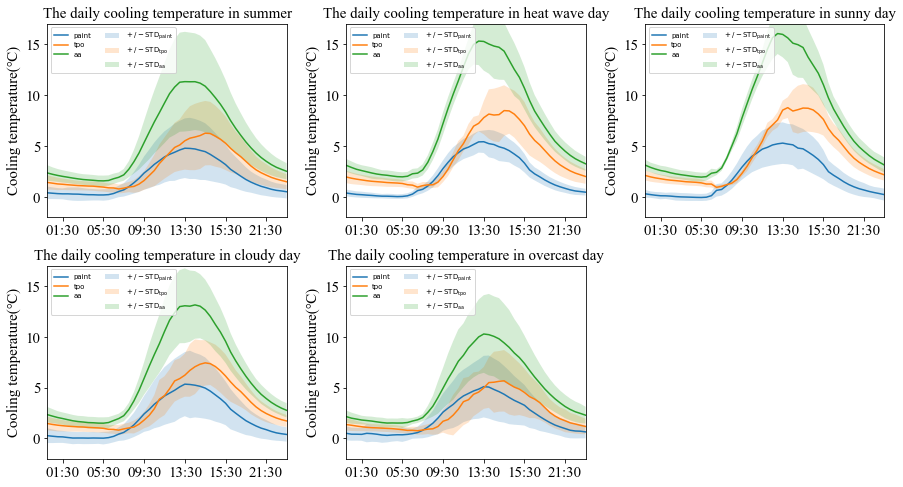

In [23]:
def draw(ax, paint_day, tpo_day, aa_day, title):
    # # paint
    ax.plot(paint_day.mean(axis=0), label='paint')  # 平均
    ax.fill_between(paint_day.mean(axis=0).index, paint_day.mean(axis=0) + paint_day.std(axis=0), 
                    paint_day.mean(axis=0) - paint_day.std(axis=0), alpha=.2, linewidth=0, label=r'${\rm +/-STD_{paint}}$')  # 加减标准差，阴影图
    # # paint
    ax.plot(tpo_day.mean(axis=0), label='tpo')  # 平均
    ax.fill_between(tpo_day.mean(axis=0).index, tpo_day.mean(axis=0) + tpo_day.std(axis=0), 
                    tpo_day.mean(axis=0) - tpo_day.std(axis=0), alpha=.2, linewidth=0, label=r'${\rm +/-STD_{tpo}}$')  # 加减标准差，阴影图
    # # paint
    ax.plot(aa_day.mean(axis=0), label='aa')  # 平均
    ax.fill_between(aa_day.mean(axis=0).index, aa_day.mean(axis=0) + aa_day.std(axis=0), 
                    aa_day.mean(axis=0) - aa_day.std(axis=0), alpha=.2, linewidth=0, label=r'${\rm +/-STD_{aa}}$')  # 加减标准差，阴影图

    # 设置y轴刻度的范围
    ax.set_ylim((-2, 17))
    ax.set_yticks(np.arange(0, 17, 5))
    ax.set_yticklabels(np.arange(0, 17, 5), fontdict=font)
    # 设置x轴刻度的范围
    ax.set_xlim((0, 47))
    ax.set_xticks(np.arange(3, 49, 8))
    ax.set_xticklabels(['01:30', '05:30', '09:30', '13:30', '15:30', '21:30'], fontdict=font)
    # 设置坐标标题
    ax.set_ylabel('Cooling temperature(℃)', fontdict=font)
    # 设置标题
    ax.set_title(title, fontdict=font)

    plt.legend(loc='upper left', ncol=2, fontsize=7)

# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 15,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(15, 8))
# # 2017年夏季平均
ax1 = fig.add_subplot(2, 3, 1)
draw(ax1, paint_2017_summer_day, tpo_2017_summer_day, aa_2017_summer_day, 'The daily cooling temperature in summer')

# # 2017年夏季高温热浪日平均
ax2 = fig.add_subplot(2, 3, 2)
draw(ax2, paint_2017_summer_day_heatwave, tpo_2017_summer_day_heatwave, aa_2017_summer_day_heatwave, 'The daily cooling temperature in heat wave day')

# # 2017年夏季晴天平均
ax3 = fig.add_subplot(2, 3, 3)
draw(ax3, paint_2017_summer_day_sunny, tpo_2017_summer_day_sunny, aa_2017_summer_day_sunny, 'The daily cooling temperature in sunny day')


# # 2017年夏季多云天平均
ax4 = fig.add_subplot(2, 3, 4)
draw(ax4, paint_2017_summer_day_cloudy, tpo_2017_summer_day_cloudy, aa_2017_summer_day_cloudy, 'The daily cooling temperature in cloudy day')

# # 2017年夏季阴天平均
ax5 = fig.add_subplot(2, 3, 5)
draw(ax5, paint_2017_summer_day_overcast, tpo_2017_summer_day_overcast, aa_2017_summer_day_overcast, 'The daily cooling temperature in overcast day')

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\不同天气条件下，2017年夏季降温幅度日变化趋势.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
def draw(num, ax, paint_day, tpo_day, aa_day):
    # # paint
    ax.plot(paint_day.mean(axis=0), linewidth=2, label=r'$\rm AC$', color='#1F77B4')  # 平均
    ax.fill_between(paint_day.mean(axis=0).index, paint_day.mean(axis=0) + paint_day.std(axis=0), 
                    paint_day.mean(axis=0) - paint_day.std(axis=0), alpha=.15, linewidth=0, 
                    label=r'${\rm \pm STD_{AC}}$', color='#1F77B4')  # 加减标准差，阴影图
    # # tpo
    ax.plot(tpo_day.mean(axis=0), linewidth=2, label=r'$\rm TPO$', color='#FF7E0E')  # 平均
    ax.fill_between(tpo_day.mean(axis=0).index, tpo_day.mean(axis=0) + tpo_day.std(axis=0), 
                    tpo_day.mean(axis=0) - tpo_day.std(axis=0), alpha=.15, linewidth=0, 
                    label=r'${\rm \pm STD_{TPO}}$', color='#FF7E0E')  # 加减标准差，阴影图
    # # aa
    ax.plot(aa_day.mean(axis=0), linewidth=2, label=r'$\rm SBS$', color='#2CA02C')  # 平均
    ax.fill_between(aa_day.mean(axis=0).index, aa_day.mean(axis=0) + aa_day.std(axis=0), 
                    aa_day.mean(axis=0) - aa_day.std(axis=0), alpha=.15, linewidth=0, 
                    label=r'${\rm \pm STD_{SBS}}$', color='#2CA02C')  # 加减标准差，阴影图

    if num == 1 or num == 2:
        # 设置x轴刻度的范围
        ax.set_xlim((0, 47))
        ax.set_xticks(np.arange(3, 49, 8))
        ax.set_xticklabels([])
    else:
        # 设置x轴刻度的范围
        ax.set_xlim((0, 47))
        ax.set_xticks(np.arange(3, 49, 8))
        ax.set_xticklabels(['01:30', '05:30', '09:30', '13:30', '15:30', '21:30'], fontdict=font)
        ax.set_xlabel('Time', fontdict=font)

    if num == 1 or num == 3:
        # 设置y轴刻度的范围
        ax.set_ylim((-2, 19))
        ax.set_yticks(np.arange(0, 19, 5))
        ax.set_yticklabels(np.arange(0, 19, 5), fontdict=font)

        # 设置坐标标题
        ax.set_ylabel('Cooling temperature (℃)', fontdict=font)
    else:
        # 设置y轴刻度的范围
        ax.set_ylim((-2, 19))
        ax.set_yticks(np.arange(0, 19, 5))
        ax.set_yticklabels([])

    plt.legend(loc='upper left', ncol=2, fontsize=8, frameon=False)
#     ax.legend(ncol=6, fontsize=7, loc='upper left', bbox_to_anchor=(-0.018, 1.19), frameon=False, columnspacing=0.2, handletextpad=0.2)

# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 8))
# # 2017年夏季平均
ax1 = fig.add_subplot(2, 2, 1)
draw(1, ax1, paint_2017_summer_day, tpo_2017_summer_day, aa_2017_summer_day)
ax1.text(43.2, 17, '(a)', fontdict=font)

# # 2017年夏季高温热浪日平均
ax2 = fig.add_subplot(2, 2, 2)
draw(2, ax2, paint_2017_summer_day_heatwave, tpo_2017_summer_day_heatwave, aa_2017_summer_day_heatwave)
ax2.text(43.2, 17, '(b)', fontdict=font)

# # 2017年夏季晴天平均
ax3 = fig.add_subplot(2, 2, 3)
draw(3, ax3, paint_2017_summer_day_sunny, tpo_2017_summer_day_sunny, aa_2017_summer_day_sunny)
ax3.text(43.2, 17, '(c)', fontdict=font)

# # 2017年夏季阴天平均
ax4 = fig.add_subplot(2, 2, 4)
draw(4, ax4, paint_2017_summer_day_overcast, tpo_2017_summer_day_overcast, aa_2017_summer_day_overcast)
ax4.text(43.2, 17, '(d)', fontdict=font)

plt.subplots_adjust(wspace=0.038, hspace=0.05)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\不同天气条件下，2017年夏季降温幅度日变化趋势2.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [15]:
with pd.ExcelWriter(r'C:\Users\NH4NO3nice\Desktop\绘图数据-降温幅度.xlsx') as f:
    paint_2017_summer_day.to_excel(f, sheet_name='paint_2017_summer_day', index=True, header=True)
    tpo_2017_summer_day.to_excel(f, sheet_name='tpo_2017_summer_day', index=True, header=True)
    aa_2017_summer_day.to_excel(f, sheet_name='aa_2017_summer_day', index=True, header=True)
    
    paint_2017_summer_day_heatwave.to_excel(f, sheet_name='paint_2017_summer_day_heatwave', index=True, header=True)
    tpo_2017_summer_day_heatwave.to_excel(f, sheet_name='tpo_2017_summer_day_heatwave', index=True, header=True)
    aa_2017_summer_day_heatwave.to_excel(f, sheet_name='aa_2017_summer_day_heatwave', index=True, header=True)
    
    paint_2017_summer_day_sunny.to_excel(f, sheet_name='paint_2017_summer_day_sunny', index=True, header=True)
    tpo_2017_summer_day_sunny.to_excel(f, sheet_name='tpo_2017_summer_day_sunny', index=True, header=True)
    aa_2017_summer_day_sunny.to_excel(f, sheet_name='aa_2017_summer_day_sunny', index=True, header=True)
    
    paint_2017_summer_day_cloudy.to_excel(f, sheet_name='paint_2017_summer_day_cloudy', index=True, header=True)
    tpo_2017_summer_day_cloudy.to_excel(f, sheet_name='tpo_2017_summer_day_cloudy', index=True, header=True)
    aa_2017_summer_day_cloudy.to_excel(f, sheet_name='aa_2017_summer_day_cloudy', index=True, header=True)
    
    paint_2017_summer_day_overcast.to_excel(f, sheet_name='paint_2017_summer_day_overcast', index=True, header=True)
    tpo_2017_summer_day_overcast.to_excel(f, sheet_name='tpo_2017_summer_day_overcast', index=True, header=True)
    aa_2017_summer_day_overcast.to_excel(f, sheet_name='aa_2017_summer_day_overcast', index=True, header=True)
    

In [18]:
def a(summer_day_mean_std, paint_2017_summer_day, tpo_2017_summer_day, aa_2017_summer_day):
    summer_day_mean_std['paint-mean'] = paint_2017_summer_day.mean(axis=0)
    summer_day_mean_std['paint-std'] = paint_2017_summer_day.std(axis=0)

    summer_day_mean_std['tpo-mean'] = tpo_2017_summer_day.mean(axis=0)
    summer_day_mean_std['tpo-std'] = tpo_2017_summer_day.std(axis=0)

    summer_day_mean_std['aa-mean'] = aa_2017_summer_day.mean(axis=0)
    summer_day_mean_std['aa-std'] = aa_2017_summer_day.std(axis=0)
    return summer_day_mean_std

summer_day_mean_std, summer_day_heatwave_mean_std, summer_day_sunny_mean_std, summer_day_cloudy_mean_std, summer_day_overcast_mean_std = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])


with pd.ExcelWriter(r'C:\Users\NH4NO3nice\Desktop\绘图数据-平均、标准差.xlsx') as f:
    a(summer_day_mean_std, paint_2017_summer_day, tpo_2017_summer_day, aa_2017_summer_day).to_excel(f, sheet_name='2017_summer_day', index=True, header=True)
    
    a(summer_day_heatwave_mean_std, paint_2017_summer_day_heatwave, tpo_2017_summer_day_heatwave, aa_2017_summer_day_heatwave).to_excel(f, sheet_name='2017_summer_day_heatwave', index=True, header=True)

    a(summer_day_sunny_mean_std, paint_2017_summer_day_sunny, tpo_2017_summer_day_sunny, aa_2017_summer_day_sunny).to_excel(f, sheet_name='2017_summer_day_sunny', index=True, header=True)
    
    a(summer_day_cloudy_mean_std, paint_2017_summer_day_cloudy, tpo_2017_summer_day_cloudy, aa_2017_summer_day_cloudy).to_excel(f, sheet_name='2017_summer_day_cloudy', index=True, header=True)
    
    a(summer_day_overcast_mean_std, paint_2017_summer_day_overcast, tpo_2017_summer_day_overcast, aa_2017_summer_day_overcast).to_excel(f, sheet_name='paint_2017_summer_day_overcast', index=True, header=True)

# 20170609-20170815太阳短波辐射与paint冷却效率的关系 

## 提取太阳辐射和降温幅度

In [57]:
# # 提取2017-06-28到2017-08-15的数据
paint_2017_summer_ = paint_2017_summer.loc[paint_2017_summer.index.hour.isin(np.arange(6, 18))].loc['2017-06-09':]

# # 深度辐射太阳短波辐射、反照率、冷却温度
paint_2017_DR = copy.deepcopy(paint_2017_summer_['DR'])
paint_2017_albedo = copy.deepcopy(paint_2017_summer_['albedo'])
paint_2017_cooling_tem = copy.deepcopy(paint_2017_summer_['cooling_temperature'])

# # 剔除
paint_2017_cooling_tem = del_data_3sigma(paint_2017_cooling_tem)

## 计算辐射日总量和降温幅度日平均

In [ ]:
paint_2017_DR = pd.DataFrame(paint_2017_DR)
paint_2017_cooling_tem = pd.DataFrame(paint_2017_cooling_tem)
paint_2017_albedo = pd.DataFrame(paint_2017_albedo)

paint_2017_DR_day = heavy_sampling_method(paint_2017_DR, '2017-06-09 00:00:00', '2017-08-16 00:00:00', '1D', 'sum', type=3)
paint_2017_cooling_tem_day = heavy_sampling_method(paint_2017_cooling_tem, '2017-06-09 00:00:00', '2018-08-16 00:00:00', '1D', 'mean', type=3)
paint_2017_albedo_day = heavy_sampling_method(paint_2017_albedo, '2017-06-09 00:00:00', '2017-08-16 00:00:00', '1D', 'mean', type=3)

## 剔除降雨日

In [59]:
# # 提取降水数据
rain_file = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\original_data\2017-2020年南京站降水量数据.xlsx'
rain = pd.read_excel(rain_file, skiprows=[1], usecols=[3, 4, 5, 8])
# # 将时间转化为时间格式
rain_time = []
for i in range(len(rain)):
    temp = str(rain.iloc[i, 0]) + '-' + str(rain.iloc[i, 1]) + '-' + str(rain.iloc[i, 2])
    rain_time.append(datetime.strptime(temp, '%Y-%m-%d'))
rain.index = rain_time
# 删除年、月、日列
rain.drop(['年', '月', '日'], axis=1, inplace=True)
# 修改列名
rain.rename(columns={'降水量': 'rainfall'}, inplace=True)
# 筛选出无降水的日
rain = rain.loc[rain['rainfall'] == 0]
paint_2017_DR_day['rainfall'] = rain
paint_2017_cooling_tem_day['rainfall'] = rain
paint_2017_albedo_day['rainfall'] = rain

paint_2017_DR_day.dropna(axis=0, how='any', inplace=True)
paint_2017_cooling_tem_day.dropna(axis=0, how='any', inplace=True)
paint_2017_albedo_day.dropna(axis=0, how='any', inplace=True)

## 一元回归分析

In [61]:
def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
# paint_line = np.polyfit(paint_day['albedo'], paint_day['cooling_temperature'], 1)
paint_line = stats.linregress(paint_2017_DR_day['DR'] / 10 ** 6, paint_2017_cooling_tem_day['cooling_temperature'])

# 计算拟合值，绘图使用
y_paint = f_fit(np.arange(9, 28, 1), paint_line)

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig, ax = plt.subplots(1, 1)
ax.scatter(paint_2017_DR_day['DR'] / 10 ** 6, paint_2017_cooling_tem_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax.plot(np.arange(9, 28, 1), y_paint, color='red')

ax.set_xlim((9.5, 27))
ax.set_xlabel(r'DR($MJ·m^{-2}$)')
ax.set_ylabel('Cooling Temperature(℃)')
ax.text(10, 6.34, 'y=' + str(np.poly1d(paint_line[:2]))[2:], color='red', fontdict=font)
ax.text(10, 5.9, 'P=' + str(round(paint_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(paint_line[2] ** 2, 2)), color='red', fontdict=font)

# ax1 = ax.twinx()
# ax1.scatter(paint_2017_DR_day['DR'], paint_2017_albedo_day['albedo'], marker='o', color='none', edgecolors='red')
# ax1.set_ylabel('Albedo')
# plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\太阳短波辐射与冷却温度的关系.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)

# 2018-2020年夏季太阳短波辐射与TPO和SBS冷却效率的关系

## 提取夏季TPO\SBS太阳反照率与降温幅度

In [180]:
# # 提取夏季数据
tpo_2018_2020_summer = tpo_2018_2020.loc[tpo_2018_2020.index.month.isin([6, 7, 8])]
aa_2018_2020_summer = aa_2018_2020.loc[aa_2018_2020.index.month.isin([6, 7, 8])]
# # 提取白天数据
tpo_2018_2020_summer_day = tpo_2018_2020_summer.loc[tpo_2018_2020_summer.index.hour.isin(np.arange(7, 18))]
aa_2018_2020_summer_day = aa_2018_2020_summer.loc[aa_2018_2020_summer.index.hour.isin(np.arange(7, 18))]

# # 深度辐射太阳短波辐射、冷却温度
tpo_2018_2020_summer_DR = copy.deepcopy(tpo_2018_2020_summer_day['DR'])
tpo_2018_2020_summer_cooling_tem = copy.deepcopy(tpo_2018_2020_summer_day['cooling_temperature'])

aa_2018_2020_summer_DR = copy.deepcopy(aa_2018_2020_summer_day['DR'])
aa_2018_2020_summer_cooling_tem = copy.deepcopy(aa_2018_2020_summer_day['cooling_temperature'])

# # 剔除
tpo_2018_2020_summer_cooling_tem = del_data_3sigma(tpo_2018_2020_summer_cooling_tem)
aa_2018_2020_summer_cooling_tem = del_data_3sigma(aa_2018_2020_summer_cooling_tem)

## 计算辐射日总量和降温幅度日平均

In [ ]:
tpo_2018_2020_summer_DR = pd.DataFrame(tpo_2018_2020_summer_DR)
tpo_2018_2020_summer_cooling_tem = pd.DataFrame(tpo_2018_2020_summer_cooling_tem)

aa_2018_2020_summer_DR = pd.DataFrame(aa_2018_2020_summer_DR)
aa_2018_2020_summer_cooling_tem = pd.DataFrame(aa_2018_2020_summer_cooling_tem)


tpo_2018_2020_summer_DR_day = heavy_sampling_method(tpo_2018_2020_summer_DR, '2018-01-01 00:00:00', '2021-01-01 00:00:00', '1D', 'sum-solar', type=3)
tpo_2018_2020_summer_cooling_tem_day = heavy_sampling_method(tpo_2018_2020_summer_cooling_tem, '2018-01-01 00:00:00', '2021-01-01 00:00:00', '1D', 'mean', type=3)

aa_2018_2020_summer_DR_day = heavy_sampling_method(aa_2018_2020_summer_DR, '2018-01-01 00:00:00', '2021-01-01 00:00:00', '1D', 'sum-solar', type=3)
aa_2018_2020_summer_cooling_tem_day = heavy_sampling_method(aa_2018_2020_summer_cooling_tem, '2018-01-01 00:00:00', '2021-01-01 00:00:00', '1D', 'mean', type=3)

## 剔除降雨日

In [182]:
# # 提取降水数据
rain_file = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\original_data\2017-2020年南京站降水量数据.xlsx'
rain = pd.read_excel(rain_file, skiprows=[1], usecols=[3, 4, 5, 8])
# # 将时间转化为时间格式
rain_time = []
for i in range(len(rain)):
    temp = str(rain.iloc[i, 0]) + '-' + str(rain.iloc[i, 1]) + '-' + str(rain.iloc[i, 2])
    rain_time.append(datetime.strptime(temp, '%Y-%m-%d'))
rain.index = rain_time
# 删除年、月、日列
rain.drop(['年', '月', '日'], axis=1, inplace=True)
# 修改列名
rain.rename(columns={'降水量': 'rainfall'}, inplace=True)
# 筛选出无降水的日
rain = rain.loc[rain['rainfall'] == 0]

# # 
tpo_2018_2020_summer_DR_cooling_tem_day = copy.deepcopy(tpo_2018_2020_summer_DR_day)
tpo_2018_2020_summer_DR_cooling_tem_day['cooling_temperature'] = tpo_2018_2020_summer_cooling_tem_day
tpo_2018_2020_summer_DR_cooling_tem_day['rainfall'] = rain

aa_2018_2020_summer_DR_cooling_tem_day = copy.deepcopy(aa_2018_2020_summer_DR_day)
aa_2018_2020_summer_DR_cooling_tem_day['cooling_temperature'] = aa_2018_2020_summer_cooling_tem_day
aa_2018_2020_summer_DR_cooling_tem_day['rainfall'] = rain

# # 删除rainfall列为nan的行，即删去雨天
tpo_2018_2020_summer_DR_cooling_tem_day.dropna(axis=0, how='any', inplace=True)
aa_2018_2020_summer_DR_cooling_tem_day.dropna(axis=0, how='any', inplace=True)
# for i in tpo_2018_2020_summer_DR_day.index:
#     if np.isnan(tpo_2018_2020_summer_DR_day.loc[i, 'rainfall']):
#         tpo_2018_2020_summer_DR_day.drop(i, axis=0, inplace=True)
#         tpo_2018_2020_summer_cooling_tem_day.drop(i, axis=0, inplace=True)
# for i in aa_2018_2020_summer_DR_day.index:
#     if np.isnan(aa_2018_2020_summer_DR_day.loc[i, 'rainfall']):
#         aa_2018_2020_summer_DR_day.drop(i, axis=0, inplace=True)
#         aa_2018_2020_summer_cooling_tem_day.drop(i, axis=0, inplace=True)

## 一元回归分析

In [183]:
def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
# paint_line = np.polyfit(paint_day['albedo'], paint_day['cooling_temperature'], 1)
tpo_line = stats.linregress(tpo_2018_2020_summer_DR_cooling_tem_day['DR'] / 10 ** 6, tpo_2018_2020_summer_DR_cooling_tem_day['cooling_temperature'])
aa_line = stats.linregress(aa_2018_2020_summer_DR_cooling_tem_day['DR'] / 10 ** 6, aa_2018_2020_summer_DR_cooling_tem_day['cooling_temperature'])

# 计算拟合值，绘图使用
y_tpo = f_fit(np.arange(2, 30, 1), tpo_line)
y_aa = f_fit(np.arange(2, 30, 1), aa_line)

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 4))
# # TPO
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(tpo_2018_2020_summer_DR_cooling_tem_day['DR'] / 10 ** 6, tpo_2018_2020_summer_DR_cooling_tem_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax1.plot(np.arange(2, 30, 1), y_tpo, color='red')

ax1.set_xlim((3.3, 28))
ax1.set_xticks(np.arange(5, 30, 5))
ax1.set_xticklabels(np.arange(5, 30, 5), fontdict=font)
ax1.set_xlabel(r'Total daily solar radiation($\rm MJ·m^{-2}$)', fontdict=font)

ax1.set_ylim((1, 7))
ax1.set_yticks(np.arange(1, 8, 1))
ax1.set_yticklabels(np.arange(1, 8, 1), fontdict=font)
ax1.set_ylabel('The daytime cooling temperature of TPO(℃)', fontdict=font)

ax1.text(4, 6.5, 'y=' + str(np.poly1d(tpo_line[:2]))[2:], color='red', fontdict=font)
if tpo_line[3] < 0.01:
    ax1.text(4, 6.05, 'P < 0.01' + '   ' + r'$\rm R^2=$' + str(round(tpo_line[2] ** 2, 2)), color='red', fontdict=font)
else:
    ax1.text(4, 6.05, 'P=' + str(round(tpo_line[3], 2)) + '   ' + r'$\rm R^2=$' + str(round(tpo_line[2] ** 2, 2)), color='red', fontdict=font)
ax1.text(25.7, 1.3, '(b)', fontdict=font)

# # SBS
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(aa_2018_2020_summer_DR_cooling_tem_day['DR'] / 10 ** 6, aa_2018_2020_summer_DR_cooling_tem_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax2.plot(np.arange(2, 30, 1), y_aa, color='red')

ax2.set_xlim((3.3, 28))
ax2.set_xticks(np.arange(5, 30, 5))
ax2.set_xticklabels(np.arange(5, 30, 5), fontdict=font)
ax2.set_xlabel(r'Total daily solar radiation($\rm MJ·m^{-2}$)', fontdict=font)

ax2.set_ylim((3, 27))
ax2.set_yticks(np.arange(5, 30, 5))
ax2.set_yticklabels(np.arange(5, 30, 5), fontdict=font)
ax2.set_ylabel('The daytime cooling temperature of SBS(℃)', fontdict=font)

ax2.text(4, 25., 'y=' + str(np.poly1d(aa_line[:2]))[2:], color='red', fontdict=font)
if aa_line[3] < 0.01:
    ax2.text(4, 23.1, 'P < 0.01' + '   ' + r'$\rmR^2=$' + str(round(aa_line[2] ** 2, 2)), color='red', fontdict=font)
else:
    ax2.text(4, 23.1, 'P=' + str(round(aa_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(aa_line[2] ** 2, 2)), color='red', fontdict=font)
ax2.text(25.7, 4.2, '(c)', fontdict=font)

# plt.subplots_adjust(wspace=0.12, hspace=0)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\TPO和SBS太阳短波辐射与冷却温度的关系.svg', bbox_inches='tight', pad_inches=0.1)

# 反照率与降温幅度关系

## 提取2017年夏季(6.9日之后)白天的反照率和降温幅度

In [98]:
# # 提取反照率和降温幅度数据
paint_albedo_coolingtem = paint_2017_summer.loc[paint_2017_summer.index.hour.isin(np.arange(6, 18))].iloc[:, 6:8].loc['2017-06-09':]
tpo_albedo_coolingtem = tpo_2017_summer.loc[tpo_2017_summer.index.hour.isin(np.arange(6, 18))].iloc[:, 6:8].loc['2017-06-09':]
aa_albedo_coolingtem = aa_2017_summer.loc[aa_2017_summer.index.hour.isin(np.arange(6, 18))].iloc[:, 6:8].loc['2017-06-09':]

# # 3sigma剔除野点
paint_albedo_coolingtem = del_data_3sigma(paint_albedo_coolingtem)
tpo_albedo_coolingtem = del_data_3sigma(tpo_albedo_coolingtem)
aa_albedo_coolingtem = del_data_3sigma(aa_albedo_coolingtem)

## 求日平均

In [ ]:
paint_day = heavy_sampling_method(paint_albedo_coolingtem, '2017-01-01 00:00:00', '2018-08-16 00:00:00', '1d', 'mean', type=3)
tpo_day = heavy_sampling_method(tpo_albedo_coolingtem, '2017-01-01 00:00:00', '2018-08-16 00:00:00', '1d', 'mean', type=3)
aa_day = heavy_sampling_method(aa_albedo_coolingtem, '2017-01-01 00:00:00', '2018-08-16 00:00:00', '1d', 'mean', type=3)

# # 剔除含有缺测NaN的时次
paint_day.dropna(axis=0, how='any', inplace=True)
tpo_day.dropna(axis=0, how='any', inplace=True)
aa_day.dropna(axis=0, how='any', inplace=True)

## 剔除降水日

In [100]:
# # 提取降水数据
rain_file = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\original_data\2017-2020年南京站降水量数据.xlsx'
rain = pd.read_excel(rain_file, skiprows=[1], usecols=[3, 4, 5, 8])
# # 将时间转化为时间格式
rain_time = []
for i in range(len(rain)):
    temp = str(rain.iloc[i, 0]) + '-' + str(rain.iloc[i, 1]) + '-' + str(rain.iloc[i, 2])
    rain_time.append(datetime.strptime(temp, '%Y-%m-%d'))
rain.index = rain_time
# 删除年、月、日列
rain.drop(['年', '月', '日'], axis=1, inplace=True)
# 修改列名
rain.rename(columns={'降水量': 'rainfall'}, inplace=True)
# 赛选出无降水的日
rain = rain.loc[rain['rainfall'] == 0]
paint_day['rainfall'] = rain
tpo_day['rainfall'] = rain
aa_day['rainfall'] = rain

paint_day.dropna(axis=0, how='any', inplace=True)
tpo_day.dropna(axis=0, how='any', inplace=True)
aa_day.dropna(axis=0, how='any', inplace=True)

## 拟合

In [101]:
def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
# paint_line = np.polyfit(paint_day['albedo'], paint_day['cooling_temperature'], 1)
paint_line = stats.linregress(paint_day['albedo'], paint_day['cooling_temperature'])
tpo_line =  stats.linregress(tpo_day['albedo'], tpo_day['cooling_temperature'])
aa_line =  stats.linregress(aa_day['albedo'], aa_day['cooling_temperature'])

# 计算拟合值，绘图使用
y_paint = f_fit(np.arange(0, 1, 0.01), paint_line)
y_tpo = f_fit(np.arange(0, 1, 0.01), tpo_line)
y_aa = f_fit(np.arange(0, 1, 0.01), aa_line)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(15, 4), dpi=300)

# # paint
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(paint_day['albedo'], paint_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax1.plot(np.arange(0, 1, 0.01), y_paint, color='red')
# 横轴
ax1.set_xlim((0.28, 0.57))
ax1.set_xticks(np.arange(0.3, 0.6, 0.05))
ax1.set_xlabel('Albedo of AC', fontdict=font)
# 纵轴
ax1.set_ylim((1.2, 6.8))
ax1.set_yticks(np.arange(2, 7, 1))
ax1.set_ylabel( 'Cooling temperature(℃)', fontdict=font)
ax1.text(0.287, 6.335, 'y=' + str(np.poly1d(paint_line[:2]))[2:], color='red', fontdict=font)
ax1.text(0.287, 5.9, 'P=' + str(round(paint_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(paint_line[2] ** 2, 2)), color='red', fontdict=font)

# # tpo
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(tpo_day['albedo'], tpo_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax2.plot(np.arange(0, 1, 0.01), y_tpo, color='red')
# 横轴
ax2.set_xlim((0.30, 0.46))
ax2.set_xticks(np.arange(0.32, 0.45, 0.02))
ax2.set_xlabel('Albedo of tpo', fontdict=font)
# 纵轴
ax2.set_ylim((2.2, 6.3))
ax2.set_yticks(np.arange(2.5, 6.2, 0.5))
ax2.set_ylabel('Cooling temperature of tpo(℃)', fontdict=font)

ax2.text(0.305, 6, 'y=' + str(np.poly1d(tpo_line[:2]))[2:], color='red', fontdict=font)
ax2.text(0.305, 5.7, 'P=' + str(round(tpo_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(tpo_line[2] ** 2, 2)), color='red', fontdict=font)


# # aa
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(aa_day['albedo'], aa_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax3.plot(np.arange(0, 1, 0.01), y_aa, color='red')
# 横轴
ax3.set_xlim((0.83, 0.93))
ax3.set_xticks(np.arange(0.84, 0.92, 0.02))
ax3.set_xlabel('Albedo of aa', fontdict=font)
# 纵轴
ax3.set_ylim((4.6, 12.2))
ax3.set_yticks(np.arange(5, 13, 1))
ax3.set_ylabel('Cooling temperature of aa(℃)', fontdict=font)
ax3.text(0.832, 11.6, 'y=' + str(np.poly1d(aa_line[:2]))[2:], color='red', fontdict=font)
ax3.text(0.832, 11, 'P=' + str(round(aa_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(aa_line[2] ** 2, 2)), color='red', fontdict=font)

# # 调整子图间距，横纵
plt.subplots_adjust(wspace=0.2, hspace=0.25)
# plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\冷却温度与反照率的关系.svg', dpi=300, bbox_inches='tight', pad_inches=0.1)

## 绘图-只画AC反照率与降温的关系

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(5, 4))

# # paint
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(paint_day['albedo'], paint_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax1.plot(np.arange(0, 1, 0.01), y_paint, color='red')
# 横轴
ax1.set_xlim((0.28, 0.57))
ax1.set_xticks(np.arange(0.3, 0.6, 0.05))
ax1.set_xticklabels([0.3, 0.35, 0.4, 0.45, 0.5, 0.55], fontdict=font)
ax1.set_xlabel('Average daytime Albedo of AC', fontdict=font)
# 纵轴
ax1.set_ylim((1.2, 6.8))
ax1.set_yticks(np.arange(2, 7, 1))
ax1.set_yticklabels(np.arange(2, 7, 1), fontdict=font)
ax1.set_ylabel('The daytime cooling temperature of AC(℃)', fontdict=font)
ax1.text(0.287, 6.335, 'y=' + str(np.poly1d(paint_line[:2]))[2:], color='red', fontdict=font)
if paint_line[3] < 0.01:
    ax1.text(0.287, 5.9, 'P < 0.01' + '   ' + r'$\rmR^2=$' + str(round(paint_line[2] ** 2, 2)), color='red', fontdict=font)
else:
    ax1.text(0.287, 5.9, 'P=' + str(round(paint_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(paint_line[2] ** 2, 2)), color='red', fontdict=font)
ax1.text(0.5475, 1.46, '(a)', fontdict=font)

plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\paint冷却温度与反照率的关系.svg', bbox_inches='tight', pad_inches=0.1)

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(5, 4))

# # paint
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(paint_day['albedo'], paint_day['cooling_temperature'], marker='o', color='none', edgecolors='black')
ax1.plot(np.arange(0, 1, 0.01), y_paint, color='red')
# 横轴
ax1.set_xlim((0.28, 0.57))
ax1.set_xticks(np.arange(0.3, 0.6, 0.05))
ax1.set_xticklabels([0.3, 0.35, 0.4, 0.45, 0.5, 0.55], fontdict=font)
ax1.set_xlabel('Albedo of AC', fontdict=font)
# 纵轴
ax1.set_ylim((1.2, 6.8))
ax1.set_yticks(np.arange(2, 7, 1))
ax1.set_yticklabels(np.arange(2, 7, 1), fontdict=font)
ax1.set_ylabel( 'AC Cooling Temperature(℃)', fontdict=font)
ax1.text(0.287, 6.335, 'y=' + str(np.poly1d(paint_line[:2]))[2:], color='red', fontdict=font)
ax1.text(0.287, 5.9, 'P=' + str(round(paint_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(paint_line[2] ** 2, 2)), color='red', fontdict=font)
ax1.text(0.5475, 1.46, '(a)', fontdict=font)

# plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\paint冷却温度与反照率的关系.svg', bbox_inches='tight', pad_inches=0.1)

# 材料反照率随时间的变化图+文献

In [ ]:
# # 提取2017-06-08到2017-08-15的数据
paint_2017_summer_608 = paint_2017_summer.loc['2017-06-08':'2017-08-15']
tpo_2017_summer_608 = tpo_2017_summer.loc['2017-06-08':'2017-08-15']
aa_2017_summer_608 = aa_2017_summer.loc['2017-06-08':'2017-08-15']

# # 深度复制反照率
paint_albedo = copy.deepcopy(paint_2017_summer_608['albedo'])
tpo_albedo = copy.deepcopy(tpo_2017_summer_608['albedo'])
aa_albedo = copy.deepcopy(aa_2017_summer_608['albedo'])

# # 求日平均
paint_albedo = pd.DataFrame(paint_albedo)
tpo_albedo = pd.DataFrame(tpo_albedo)
aa_albedo = pd.DataFrame(aa_albedo)

paint_albedo_day = heavy_sampling_method(paint_albedo, '2017-06-08 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)
tpo_albedo_day = heavy_sampling_method(tpo_albedo, '2017-06-08 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)
aa_albedo_day = heavy_sampling_method(aa_albedo, '2017-06-08 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)

In [84]:
# # 补全为连续日期
def buquan(data):
    date = pd.DataFrame([], index=pd.date_range('2017-06-08', '2017-08-15'))
    date['num'] = np.arange(len(pd.date_range('2017-06-08', '2017-08-15')))
    date['albedo'] = data
    return date

paint_albedo_day = buquan(paint_albedo_day)
tpo_albedo_day = buquan(tpo_albedo_day)
aa_albedo_day = buquan(aa_albedo_day)

## 计算paint反照率的时间拟合直线对比

In [85]:
# # paint反照率的时间拟合直线
def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
paint_albedo_day.dropna(axis=0, how='any', inplace=True)
paint_line = stats.linregress(paint_albedo_day['num'], paint_albedo_day['albedo'])
paper1_line = stats.linregress([0, 4 * 365], [0.74, 0.74 * 0.75]) 
paper2_line = stats.linregress([0, 18 * 30], [0.9, 0.9 * (1 - 0.279)]) 

# 计算拟合值，绘图使用
y_paint = f_fit(np.arange(0, 69), paint_line)
y_paper1 = f_fit(np.arange(0, 69), paper1_line)
y_paper2 = f_fit(np.arange(0, 69), paper2_line)

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig, ax = plt.subplots(1, 1)
ax.plot(paint_albedo_day['num'], paint_albedo_day['albedo'], marker='^', label='Albedo(AC)')
ax.plot(tpo_albedo_day['num'], tpo_albedo_day['albedo'], marker='^', label='Albedo(TPO)')
ax.plot(aa_albedo_day['num'], aa_albedo_day['albedo'], marker='^', label='Albedo(SBS)')

ax.plot(np.arange(0, 69), y_paint, linestyle='--', linewidth=2, label='Nanjing, China(2017), ' + 'y=' + str(np.poly1d(paint_line[:2]))[2:])
ax.plot(np.arange(0, 69), y_paper1, linestyle='--', linewidth=2, label='Athens, Greece(2008), ' + 'y=' + str(np.poly1d(paper1_line[:2]))[2:])
ax.plot(np.arange(0, 69), y_paper2, linestyle='--', color='#FFC125', linewidth=2, label='São Carlos, SP, Brazil(2011), ' + 'y=' + str(np.poly1d(paper2_line[:2]))[2:])

# # 设置横坐标
ax.set_xlim((0, 68))
ax.set_xticks(np.arange(0, 68, 5))
temp_time = pd.date_range('2017-06-08', '2017-08-15')
ticks = []
for i in range(0, 68, 5):
    month = str(temp_time[i])[6]
    day = str(temp_time[i])[8:10]
    if day[0] == '0':
        day = day[1]
    if i == 0:
        ticks.append(month + '/' + day + '(' + str(i + 1) + 'st)')
    else:
        ticks.append(month + '/' + day + '(' + str(i + 1) + 'th)')
        
ax.set_xticklabels(ticks, rotation=45)

# # 设置纵坐标
ax.set_ylim((0, 1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel('Alebdo')

ax.text(63.5, 0.05, '(b)', fontdict=font)

# # 设置图例
ax.legend(ncol=1, loc='lower left', fontsize=7)
# plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\20170608-20170815反照率随时间的变化.svg', bbox_inches='tight', pad_inches=0.1)

# paint反照率2017年重涂前后随时间的变化

In [388]:
# # paint反照率的时间拟合直线
def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b


class preprocess_paint():

    def __init__(self, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time

    def getData_mean1d_line(self, paint_2017, roof_2017):
        # # 提取指定段的数据
        paint_2017_401 = paint_2017.loc[self.start_time:self.end_time]
        roof_2017_401 = roof_2017.loc[self.start_time:self.end_time]

        # # 深度复制反照率
        paint_albedo = copy.deepcopy(paint_2017_401['albedo'])
        roof_albedo = copy.deepcopy(roof_2017_401['albedo'])

        # # 求日平均
        paint_albedo = pd.DataFrame(paint_albedo)
        roof_albedo = pd.DataFrame(roof_albedo)

        self.paint_albedo_day = heavy_sampling_method(paint_albedo, '2017-01-01 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)
        self.roof_albedo_day = heavy_sampling_method(roof_albedo, '2017-01-01 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)

        # # 补全为连续日期
        self.paint_albedo_day = self.buquan(self.paint_albedo_day)
        self.roof_albedo_day = self.buquan(self.roof_albedo_day)

        # # 一元线性拟合
        self.paint_albedo_day.dropna(axis=0, how='any', inplace=True)
        self.paint_line = stats.linregress(self.paint_albedo_day['num'], self.paint_albedo_day['albedo'])
        self.paper1_line = stats.linregress([0, 4 * 365], [0.74, 0.74 * 0.75]) 
        self.paper2_line = stats.linregress([0, 18 * 30], [0.9, 0.9 * (1 - 0.279)]) 

        # 计算拟合值，绘图使用
        self.y_paint = f_fit(np.arange(0, 69), self.paint_line)
        self.y_paper1 = f_fit(np.arange(0, 69), self.paper1_line)
        self.y_paper2 = f_fit(np.arange(0, 69), self.paper2_line)

    # # 补全为连续日期
    def buquan(self, data):
        date = pd.DataFrame([], index=pd.date_range(self.start_time, self.end_time))
        date['num'] = np.arange(len(pd.date_range(self.start_time, self.end_time)))
        date['albedo'] = data
        return date

## 计算

In [ ]:
# # 重涂前
repaint_401 = preprocess_paint('2017-04-01', '2017-06-07')  # 创建实例
repaint_401.getData_mean1d_line(paint_2017, roof_2017)

# # 重涂后
repaint_608 = preprocess_paint('2017-06-08', '2017-08-15')  # 创建实例
repaint_608.getData_mean1d_line(paint_2017, roof_2017)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 4))
# # 重涂前
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(repaint_401.paint_albedo_day['num'], repaint_401.paint_albedo_day['albedo'], marker='^', label='Albedo(AC)', color='#1F77B4')
ax1.scatter(repaint_401.roof_albedo_day['num'], repaint_401.roof_albedo_day['albedo'], marker='^', label='Albedo(Roof)', color='#000000')

# ax1.plot(np.arange(0, 69), f_fit(np.arange(58, 58 + 69), repaint_608.paint_line), linestyle='--', linewidth=2, 
#         label='AC: ' + 'y=' + str(np.poly1d(repaint_608.paint_line[:2]))[2:]+ '   ' + 
#         'P < 0.01' + '   ' +
#         r'$\rmR^2=$' + str(round(repaint_608.paint_line[2] ** 2, 2)), color='#1F77B4')
ax1.plot([], [], linestyle='--', linewidth=2, 
        label='AC: ' + 'y=' + str(np.poly1d(repaint_608.paint_line[:2]))[2:]+ '   ' + 
        'P < 0.01' + '   ' +
        r'$\rmR^2=$' + str(round(repaint_608.paint_line[2] ** 2, 2)), color='#1F77B4')
# ax.plot(np.arange(0, 69), repaint_401.y_paper1, linestyle='--', linewidth=2, label='Athens, Greece(2008),' + 'y=' + str(np.poly1d(repaint_401.paper1_line[:2]))[2:])
# ax.plot(np.arange(0, 69), repaint_401.y_paper2, linestyle='--', color='#FFC125', linewidth=2, label='São Carlos, SP, Brazil(2011), ' + 'y=' + str(np.poly1d(repaint_401.paper2_line[:2]))[2:])

# # 设置横坐标
ax1.set_xlim((0, 68))
ax1.set_xticks(np.arange(0, 68, 5))
ax1.set_xticklabels(np.arange(58, 58 + 68, 5), fontdict=font)
ax1.set_xlabel('Days after the first application', fontdict=font)

# # 设置纵坐标
ax1.set_ylim((0.05, 0.8))
ax1.set_yticks(np.arange(0.1, 0.9, 0.2))
ax1.set_yticklabels([0.1, 0.3, 0.5, 0.7], fontdict=font)
ax1.set_ylabel('Alebdo', fontdict=font)
# # 设置标号
ax1.text(62, 0.086, '(c)', fontdict=font)

# # 重涂后
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(repaint_608.paint_albedo_day['num'], repaint_608.paint_albedo_day['albedo'], marker='^', label='Albedo(AC)', color='#1F77B4')
ax2.scatter(repaint_608.roof_albedo_day['num'], repaint_608.roof_albedo_day['albedo'], marker='^', label='Albedo(Roof)', color='#000000')

ax2.plot(np.arange(0, 69), repaint_608.y_paint, linestyle='--', linewidth=2, 
        label='AC: ' + 'y=' + str(np.poly1d(repaint_608.paint_line[:2]))[2:] + '   ' + 
        'P < 0.01' + '   ' +
        r'$\rmR^2=$' + str(round(repaint_608.paint_line[2] ** 2, 2)), color='#1F77B4')
# ax.plot(np.arange(0, 69), repaint_608.y_paper1, linestyle='--', linewidth=2, label='Athens, Greece(2008),' + 'y=' + str(np.poly1d(repaint_608.paper1_line[:2]))[2:])
# ax.plot(np.arange(0, 69), repaint_608.y_paper2, linestyle='--', color='#FFC125', linewidth=2, label='São Carlos, SP, Brazil(2011), ' + 'y=' + str(np.poly1d(repaint_608.paper2_line[:2]))[2:])

# # 设置横坐标
ax2.set_xlim((0, 68))
ax2.set_xticks(np.arange(0, 68, 5))
ax2.set_xticklabels(np.arange(1, 68, 5), fontdict=font)
ax2.set_xlabel('Days after the second application', fontdict=font)

# # 设置纵坐标
ax2.set_ylim((0.05, 0.8))
ax2.set_yticks([])
# # 设置标号
ax2.text(62.5, 0.086, '(d)', fontdict=font)

# # 设置图例
ax1.legend(ncol=1, loc='upper left', fontsize=10)

plt.subplots_adjust(wspace=0.038, hspace=0.)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\paint重涂前后反照率随时间的变化.svg', bbox_inches='tight', pad_inches=0.1)

# 清扫TPO表面之后，反照率随时间的变化拟合

## 获取清扫TPO表面之后白天的数据

In [374]:
roof_qingsao = roof.loc['2017-06-28':]
tpo_qingsao = tpo.loc['2017-06-28':]
aa_qingsao = aa.loc['2017-06-28':]

# # 提取白天的数据6:00-17:00
daytime_roof_qingsao = roof_qingsao.loc[roof_qingsao.index.hour.isin(np.arange(10, 14))]
daytime_tpo_qingsao = tpo_qingsao.loc[tpo_qingsao.index.hour.isin(np.arange(10, 14))]
daytime_aa_qingsao = aa_qingsao.loc[aa_qingsao.index.hour.isin(np.arange(10, 14))]

## 计算白天平均数据

In [ ]:
daytime_roof_qingsao_1d = heavy_sampling_method(daytime_roof_qingsao, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1d', 'mean', type=3)
daytime_tpo_qingsao_1d = heavy_sampling_method(daytime_tpo_qingsao, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1d', 'mean', type=3)
daytime_aa_qingsao_1d = heavy_sampling_method(daytime_aa_qingsao, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1d', 'mean', type=3)

## 异常值剔除

In [376]:
daytime_roof_qingsao_1d['albedo'] = del_data_3sigma(daytime_roof_qingsao_1d['albedo'])
daytime_tpo_qingsao_1d['albedo'] = del_data_3sigma(daytime_tpo_qingsao_1d['albedo'])
daytime_aa_qingsao_1d['albedo'] = del_data_3sigma(daytime_aa_qingsao_1d['albedo'])

daytime_roof_qingsao_1d['albedo'] = del_data_3sigma(daytime_roof_qingsao_1d['albedo'])
daytime_tpo_qingsao_1d['albedo'] = del_data_3sigma(daytime_tpo_qingsao_1d['albedo'])
daytime_aa_qingsao_1d['albedo'] = del_data_3sigma(daytime_aa_qingsao_1d['albedo'])

daytime_roof_qingsao_1d['albedo'] = del_data_3sigma(daytime_roof_qingsao_1d['albedo'])
daytime_tpo_qingsao_1d['albedo'] = del_data_3sigma(daytime_tpo_qingsao_1d['albedo'])
daytime_aa_qingsao_1d['albedo'] = del_data_3sigma(daytime_aa_qingsao_1d['albedo'])

daytime_roof_qingsao_1d['albedo'] = del_data_3sigma(daytime_roof_qingsao_1d['albedo'])
daytime_tpo_qingsao_1d['albedo'] = del_data_3sigma(daytime_tpo_qingsao_1d['albedo'])
daytime_aa_qingsao_1d['albedo'] = del_data_3sigma(daytime_aa_qingsao_1d['albedo'])

daytime_roof_qingsao_1d['albedo'] = del_data_3sigma(daytime_roof_qingsao_1d['albedo'])
daytime_tpo_qingsao_1d['albedo'] = del_data_3sigma(daytime_tpo_qingsao_1d['albedo'])
daytime_aa_qingsao_1d['albedo'] = del_data_3sigma(daytime_aa_qingsao_1d['albedo'])

## 回归分析

In [219]:
# # 深拷贝
roof_1d_abeldo = copy.deepcopy(daytime_roof_qingsao_1d['albedo'])
tpo_1d_abeldo = copy.deepcopy(daytime_tpo_qingsao_1d['albedo'])
aa_1d_abeldo = copy.deepcopy(daytime_aa_qingsao_1d['albedo'])

# # 补全
def buquan(time, data):
    temp = pd.DataFrame(np.arange(len(time)), index=time)
    temp['albedo'] = data
    return temp['albedo']

time_roof = pd.date_range(roof_1d_abeldo.index[0], roof_1d_abeldo.index[-1], freq='1d')
time_tpo = pd.date_range(tpo_1d_abeldo.index[0], tpo_1d_abeldo.index[-1], freq='1d')
time_aa = pd.date_range(aa_1d_abeldo.index[0], aa_1d_abeldo.index[-1], freq='1d')

roof_1d_abeldo = buquan(time_roof, roof_1d_abeldo)
tpo_1d_abeldo = buquan(time_tpo, tpo_1d_abeldo)
aa_1d_abeldo = buquan(time_aa, aa_1d_abeldo)

# # 考虑缺测，虽然要去除缺测，但是索引仍然考虑缺测
# 将索引换成编号
roof_1d_abeldo.index = np.arange(1, len(roof_1d_abeldo) + 1)
tpo_1d_abeldo.index = np.arange(1, len(tpo_1d_abeldo) + 1)
aa_1d_abeldo.index = np.arange(1, len(aa_1d_abeldo) + 1)
# 去除缺测，保留原索引
roof_1d_abeldo.dropna(axis=0, how='all', inplace=True)
tpo_1d_abeldo.dropna(axis=0, how='all', inplace=True)
aa_1d_abeldo.dropna(axis=0, how='all', inplace=True)

def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
roof_line = stats.linregress(roof_1d_abeldo.index, roof_1d_abeldo) 
tpo_line = stats.linregress(tpo_1d_abeldo.index, tpo_1d_abeldo)
aa_line = stats.linregress(aa_1d_abeldo.index, aa_1d_abeldo)

# 计算拟合值，绘图使用
y_roof = f_fit(np.arange(len(time_roof)), roof_line)
y_tpo = f_fit(np.arange(len(time_tpo)), tpo_line)
y_aa = f_fit(np.arange(len(time_aa)), aa_line)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 2.8), dpi=300)
# # 反照率
ax = fig.add_subplot(1, 1, 1)
ax.scatter(daytime_roof_qingsao_1d.index, daytime_roof_qingsao_1d['albedo'], s=5, label='roof')
ax.scatter(daytime_tpo_qingsao_1d.index, daytime_tpo_qingsao_1d['albedo'], s=5, label='TPO')
ax.scatter(daytime_aa_qingsao_1d.index, daytime_aa_qingsao_1d['albedo'], s=5, label='SBS')

ax.plot(time_roof, y_roof, linestyle='--', linewidth=1.5)
ax.plot(time_tpo, y_tpo, linestyle='--', linewidth=1.5)
ax.plot(time_aa, y_aa, linestyle='--', linewidth=1.5)
# 纵坐标刻度和标签
ax.set_ylabel('Albedo', fontdict=font)
ax.set_ylim((0.1, 0.95))
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8], fontdict=font)
# 横坐标刻度和标签
ax.set_xlim((datetime.strptime('2017-06-28', '%Y-%m-%d'),datetime.strptime('2020-10-14', '%Y-%m-%d')))
ax.set_xlabel('Days after cleaning TPO membrane', fontdict=font)
ax.set_xticks(pd.date_range('2017-06-28', '2020-10-11', freq='100D'))
ax.set_xticklabels(np.arange(1, 1211, 100), fontdict=font)
# 图例
# ax.legend(loc='upper right', ncol=3, fontsize=10, columnspacing=0.3, handletextpad=0.2)
# 标注
x1 = datetime.strptime('2018-07-01', '%Y-%m-%d')
x2 = datetime.strptime('2019-04-01', '%Y-%m-%d')
x3 = datetime.strptime('2017-12-01', '%Y-%m-%d')

ax.annotate('y=' + str(np.poly1d(aa_line[:2]))[2:] + '   ' + 
            'P < 0.01' + '   ' + 
            r'$\rmR^2=$' + str(round(aa_line[2] ** 2, 2)), xy=(x1, 0.66), xycoords='data',
            xytext=(5, 35), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
ax.annotate('y=' + str(np.poly1d(tpo_line[:2]))[2:] + '   ' + 
            'P < 0.01' + '   ' + 
            r'$\rmR^2=$' + str(round(tpo_line[2] ** 2, 2)), xy=(x2, 0.432), xycoords='data',
            xytext=(2, 45), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
ax.annotate('y=' + str(np.poly1d(roof_line[:2]))[2:] + '   ' + 
            'P < 0.01' + '   ' + 
            r'$\rmR^2=$' + str(round(roof_line[2] ** 2, 2)), xy=(x3, 0.224), xycoords='data',
            xytext=(5, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# # 添加图标
x4 = datetime.strptime('2020-08-25', '%Y-%m-%d')
ax.text(x4, 0.85, '(e)', fontdict=font)

# plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\2018-2020反照率随时间的变化.svg', bbox_inches='tight', pad_inches=0.1)

## 更改拟合初值

In [378]:
# # 深拷贝
roof_1d_abeldo = copy.deepcopy(daytime_roof_qingsao_1d['albedo'])
tpo_1d_abeldo = copy.deepcopy(daytime_tpo_qingsao_1d['albedo'])
aa_1d_abeldo = copy.deepcopy(daytime_aa_qingsao_1d['albedo'])

# # 补全
def buquan(time, data):
    temp = pd.DataFrame(np.arange(len(time)), index=time)
    temp['albedo'] = data
    return temp['albedo']

time_roof = pd.date_range(roof_1d_abeldo.index[0], roof_1d_abeldo.index[-1], freq='1d')
time_tpo = pd.date_range(tpo_1d_abeldo.index[0], tpo_1d_abeldo.index[-1], freq='1d')
time_aa = pd.date_range(aa_1d_abeldo.index[0], aa_1d_abeldo.index[-1], freq='1d')

roof_1d_abeldo = buquan(time_roof, roof_1d_abeldo)
tpo_1d_abeldo = buquan(time_tpo, tpo_1d_abeldo)
aa_1d_abeldo = buquan(time_aa, aa_1d_abeldo)

# # 考虑缺测，虽然要去除缺测，但是索引仍然考虑缺测
# 将索引换成编号
roof_1d_abeldo.index = np.arange(146, 146 + len(roof_1d_abeldo))
tpo_1d_abeldo.index = np.arange(146, 146 + len(tpo_1d_abeldo))
aa_1d_abeldo.index = np.arange(146, 146 + len(aa_1d_abeldo))
# 去除缺测，保留原索引
roof_1d_abeldo.dropna(axis=0, how='all', inplace=True)
tpo_1d_abeldo.dropna(axis=0, how='all', inplace=True)
aa_1d_abeldo.dropna(axis=0, how='all', inplace=True)


# # 设置拟合函数形式
def func_aa(x, a):
    return a * x + 0.92
def func_tpo(x, a):
    return a * x + 0.45
def func_roof(x, a, b):
    return a * x + b
popt_roof, pcov_roof = curve_fit(func_roof, roof_1d_abeldo.index, roof_1d_abeldo)
popt_tpo, pcov_tpo = curve_fit(func_tpo, tpo_1d_abeldo.index, tpo_1d_abeldo)
popt_aa, pcov_aa = curve_fit(func_aa, aa_1d_abeldo.index, aa_1d_abeldo)

y_roof = [x * popt_roof[0] + popt_roof[1] for x in np.arange(146, 146 + len(time_roof))]
y_tpo = [x * popt_tpo[0] + 0.45 for x in np.arange(146, 146 + len(time_tpo))]
y_aa = [x * popt_aa[0] + 0.92 for x in np.arange(146, 146 + len(time_aa))]

# # 计算R方和P值
def P_R2(y1, y2):
    y1 = np.array(y1)
    y2 = np.array(y2)
    t, p = stats.ttest_ind(y1, y2)
    
    # 计算相关系数
    Sy1y2 = np.sum((y1 - np.mean(y1)) * (y2 - np.mean(y2)))
    Sy1 = np.sqrt(np.sum((y1 - np.mean(y1)) ** 2))
    Sy2 = np.sqrt(np.sum((y2 - np.mean(y2)) ** 2))
    r = Sy1y2 / (Sy1 * Sy2)
    return p, r ** 2

p_roof, R2_roof = P_R2(roof_1d_abeldo, func_roof(roof_1d_abeldo.index, popt_roof[0], popt_roof[1]))
p_tpo, R2_tpo = P_R2(tpo_1d_abeldo, func_tpo(tpo_1d_abeldo.index, popt_tpo[0]))
p_aa, R2_aa = P_R2(aa_1d_abeldo, func_aa(aa_1d_abeldo.index, popt_aa[0]))

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 2.8), dpi=300)
# # 反照率
ax = fig.add_subplot(1, 1, 1)
ax.scatter(daytime_roof_qingsao_1d.index, daytime_roof_qingsao_1d['albedo'], s=5, label='roof', color='#000000')
ax.scatter(daytime_tpo_qingsao_1d.index, daytime_tpo_qingsao_1d['albedo'], s=5, label='TPO', color='#FF7E0E')
ax.scatter(daytime_aa_qingsao_1d.index, daytime_aa_qingsao_1d['albedo'], s=5, label='SBS', color='#2CA02C')

ax.plot(time_roof, y_roof, linestyle='--', linewidth=2, color='#000000')
ax.plot(time_tpo, y_tpo, linestyle='--', linewidth=2, color='#FF7E0E')
ax.plot(time_aa, y_aa, linestyle='--', linewidth=2, color='#2CA02C')
# 纵坐标刻度和标签
ax.set_ylabel('Albedo', fontdict=font)
ax.set_ylim((0.1, 0.95))
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels([0.2, 0.4, 0.6, 0.8], fontdict=font)
# 横坐标刻度和标签
ax.set_xlim((datetime.strptime('2017-06-28', '%Y-%m-%d'),datetime.strptime('2020-10-14', '%Y-%m-%d')))
ax.set_xlabel('Days after cleaning TPO membrane', fontdict=font)
ax.set_xticks(pd.date_range('2017-06-28', '2020-10-11', freq='100D'))
ax.set_xticklabels(np.arange(146, 1347, 100), fontdict=font)
# 图例
# ax.legend(loc='upper right', ncol=3, fontsize=10, columnspacing=0.3, handletextpad=0.2)
# 标注
x1 = datetime.strptime('2018-08-01', '%Y-%m-%d')
x2 = datetime.strptime('2019-04-01', '%Y-%m-%d')
x3 = datetime.strptime('2017-12-01', '%Y-%m-%d')

ax.annotate('y=' + str(round(popt_aa[0], 6)) + 'x + 0.92' +  '   ' + 
            'P < 0.01' + '   ' + 
            r'$\rmR^2=$' + str(round(R2_aa, 2)), xy=(x1, 0.69), xycoords='data',
            xytext=(5, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'), fontsize=13)
ax.annotate('y=' + str(round(popt_tpo[0], 6)) + 'x + 0.45' + '   ' + 
            'P < 0.01' + '   ' + 
            r'$\rmR^2=$' + str(round(R2_tpo, 2)), xy=(x2, 0.412), xycoords='data',
            xytext=(2, 60), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'), fontsize=13)
ax.annotate('y=' + str(round(popt_roof[0], 6)) + 'x + ' + str(round(popt_roof[1], 2)) +  '   ' + 
            'P < 0.01' + '   ' + 
            r'$\rmR^2=$' + str(round(R2_roof, 2)), xy=(x3, 0.21), xycoords='data',
            xytext=(5, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'), fontsize=13)

# # 添加图标
x4 = datetime.strptime('2020-08-25', '%Y-%m-%d')
ax.text(x4, 0.85, '(e)', fontdict=font)

plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\2018-2020反照率随时间的变化.svg', bbox_inches='tight', pad_inches=0.1)

# AA和TPO反照率随时间的变化

In [393]:
# # paint反照率的时间拟合直线
def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b


class preprocess_tpo_aa():

    def __init__(self, start_time, end_time, type):
        self.start_time = start_time
        self.end_time = end_time
        self.type = type

    def getData_mean1d_line(self, tpo_2017, aa_2017, roof_2017):
        # # 提取指定段的数据
        aa_2017_401 = aa_2017.loc[self.start_time:self.end_time]
        tpo_2017_401 = tpo_2017.loc[self.start_time:self.end_time]
        roof_2017_401 = roof_2017.loc[self.start_time:self.end_time]

        # # 深度复制反照率
        tpo_albedo = copy.deepcopy(tpo_2017_401['albedo'])
        aa_albedo = copy.deepcopy(aa_2017_401['albedo'])
        roof_albedo = copy.deepcopy(roof_2017_401['albedo'])

        # # 求日平均
        aa_albedo = pd.DataFrame(aa_albedo)
        tpo_albedo = pd.DataFrame(tpo_albedo)
        roof_albedo = pd.DataFrame(roof_albedo)

        self.tpo_albedo_day = heavy_sampling_method(tpo_albedo, '2017-01-01 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)
        self.aa_albedo_day = heavy_sampling_method(aa_albedo, '2017-01-01 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)
        self.roof_albedo_day = heavy_sampling_method(roof_albedo, '2017-01-01 00:00:00', '2017-08-17 00:00:00', '1D', 'mean', type=3)

        # # 补全为连续日期
        self.aa_albedo_day = self.buquan(self.aa_albedo_day, self.type)
        self.tpo_albedo_day = self.buquan(self.tpo_albedo_day, self.type)
        self.roof_albedo_day = self.buquan(self.roof_albedo_day, self.type)

        # # 一元线性拟合
        self.tpo_albedo_day.dropna(axis=0, how='any', inplace=True)
        self.aa_albedo_day.dropna(axis=0, how='any', inplace=True)
        self.tpo_line = stats.linregress(self.tpo_albedo_day['num'], self.tpo_albedo_day['albedo'])
        self.aa_line = stats.linregress(self.aa_albedo_day['num'], self.aa_albedo_day['albedo'])

        # 计算拟合值，绘图使用
        self.y_aa = f_fit(np.arange(0, 150), self.aa_line)
        self.y_tpo = f_fit(np.arange(0, 150), self.tpo_line)

    # # 补全为连续日期
    def buquan(self, data, type):
        date = pd.DataFrame([], index=pd.date_range(self.start_time, self.end_time))
        if type == 'afdedust':
            date['num'] = np.arange(1, len(pd.date_range(self.start_time, self.end_time)) + 1)
        elif type == 'bededust':
            date['num'] = np.arange(58, 58 + len(pd.date_range(self.start_time, self.end_time)))
        date['albedo'] = data
        return date

## 计算

In [ ]:
# # 清灰前
deduct_401 = preprocess_tpo_aa('2017-04-01', '2017-06-27', 'bededust')
deduct_401.getData_mean1d_line(tpo_2017, aa_2017, roof_2017)

# # 清灰后
deduct_628 = preprocess_tpo_aa('2017-06-28', '2017-08-15', 'afdedust')
deduct_628.getData_mean1d_line(tpo_2017, aa_2017, roof_2017)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 4))
# # 清灰前
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(deduct_401.tpo_albedo_day['num'], deduct_401.tpo_albedo_day['albedo'], marker='^', label='Albedo(TPO)', color='#FF7E0E')
ax1.scatter(deduct_401.aa_albedo_day['num'], deduct_401.aa_albedo_day['albedo'], marker='^', label='Albedo(SBS)', color='#2CA02C')

ax1.plot(np.arange(0, 150), deduct_401.y_tpo, linestyle='--', linewidth=2, 
        label='TPO: ' + 'y=' + str(np.poly1d(deduct_401.tpo_line[:2]))[2:] + '   ' + 
        'P=' + str(round(deduct_401.tpo_line[3], 2)) + '   ' + 
        r'$\rmR^2=$' + str(round(deduct_401.tpo_line[2] ** 2, 3)), color='#FF7E0E') 
ax1.plot(np.arange(0, 150), deduct_401.y_aa, linestyle='--', linewidth=2, 
        label='SBS: ' + 'y=' + str(np.poly1d(deduct_401.aa_line[:2]))[2:] + '   ' + 
        'P=' + str(round(deduct_401.aa_line[3], 2)) + '   ' + 
        r'$\rmR^2=$' + str(round(deduct_401.aa_line[2] ** 2, 3)), color='#2CA02C')

# # 设置横坐标
ax1.set_xlim((58, 146))
ax1.set_xticks(np.arange(58, 146, 10))
ax1.set_xticklabels(np.arange(58, 146, 10), fontdict=font)
ax1.set_xlabel('Days after first application', fontdict=font)

# # 设置纵坐标
ax1.set_ylim((0, 1))
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontdict=font)
ax1.set_ylabel('Alebdo', fontdict=font)
# # 设置标号
ax1.text(138.4, 0.04, '(a)', fontdict=font)
# # 设置图例
ax1.legend(ncol=1, loc='lower left', fontsize=9)

# # 清灰后
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(deduct_628.tpo_albedo_day['num'], deduct_628.tpo_albedo_day['albedo'], marker='^', label='Albedo(TPO)', color='#FF7E0E')
ax2.scatter(deduct_628.aa_albedo_day['num'], deduct_628.aa_albedo_day['albedo'], marker='^', label='Albedo(SBS)', color='#2CA02C')

ax2.plot(np.arange(0, 150), deduct_628.y_tpo, linestyle='--', linewidth=2, 
        label='TPO: ' + 'y=' + str(np.poly1d(deduct_628.tpo_line[:2]))[2:] + '   ' + 
        'P=' + str(round(deduct_628.tpo_line[3], 2)) + '   ' + 
        r'$\rmR^2=$' + str(round(deduct_628.tpo_line[2] ** 2, 3)), color='#FF7E0E') 
ax2.plot(np.arange(0, 150), deduct_628.y_aa, linestyle='--', linewidth=2, 
        label='SBS: ' + 'y=' + str(np.poly1d(deduct_628.aa_line[:2]))[2:] + '   ' + 
        'P=' + str(round(deduct_628.aa_line[3], 2)) + '   ' + 
        r'$\rmR^2=$' + str(round(deduct_628.aa_line[2] ** 2, 3)), color='#2CA02C')

# # 设置横坐标
ax2.set_xlim((1, 49))
ax2.set_xticks(np.arange(1, 50, 5))
ax2.set_xticklabels(np.arange(1, 50, 5), fontdict=font)
ax2.set_xlabel('Days after dedusting', fontdict=font)

# # 设置纵坐标
ax2.set_ylim((0, 1))
ax2.set_yticks([])
# # 设置标号
ax2.text(44.9, 0.04, '(b)', fontdict=font)
# # 设置图例
ax2.legend(ncol=1, loc='lower left', fontsize=9)

plt.subplots_adjust(wspace=0.038, hspace=0.)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\tpo-aa清灰前后反照率随时间的变化.svg', bbox_inches='tight', pad_inches=0.1)

# PM10与降水的对比

## 获取PM10数据

In [ ]:
# # 提取PM10的数据
path1 = r'C:\Users\NH4NO3nice\Desktop\Stratospheric ozone intrusion\\'
path = os.listdir(path1)  # 获取该文件下的所有文件名
path = list(filter(lambda x: x[-4:] == '.zip', path))  # 判断files是否是.zip，并返回是.zip的数组
path = list(filter(lambda x: x[:7] in ['城市_2017', '城市_2018', '城市_2019', '城市_2020'], path))  # 判断files是否是城市开头，避免其他压缩包

# 读取解压后文件夹中的各.csv文件
file_csv = []
path = [path1 + x[:-4] for x in path]  # 在前面补全解压后文件夹的地址，去掉了'.zip'
for i in path:
    file_csv = file_csv + get_Innermost_file(i + '\\', '.csv')
# 提取数据
all_data = pd.DataFrame([])
data_type = {'date': object, 'hour': object, 'type': object, '南京': np.float32}
for f in file_csv:
    data = pd.read_csv(f, usecols=['date', 'hour', 'type', '南京'], na_values=' ', dtype=data_type, encoding='UTF-8')
    all_data = pd.concat([all_data, data], axis=0)
pm10 = all_data[all_data.type == 'PM10']  # 提取PM10的行

# 将pm10中的字符串格式的时间转换成时间戳
# 将字符串改为2018-01-01 10:00:00这种格式
pm10_time = []  # 储存转换好的时间戳
for i in range(len(pm10.date)):
    pm10_time.append(pm10.date.iloc[i][:4] + '-' + pm10.date.iloc[i][4:6] + '-' + pm10.date.iloc[i][6:8] + ' ' + pm10.hour.iloc[i] + ':00:00')
pm10_time = np.array(list([datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in pm10_time]))
# 将上面的时间格式作为索引
pm10.index = pm10_time
# 删除多余列
pm10.drop(['date', 'hour', 'type'], axis=1, inplace=True)
# 修改列名
pm10.rename(columns={'南京': 'PM10'}, inplace=True)
# # 计算月平均PM10浓度
pm10_1mon = heavy_sampling_method(pm10, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1M', 'mean', type=3)

## 获取降水数据

In [ ]:
# # 提取降水数据
rain_file = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\original_data\2017-2020年南京站降水量数据.xlsx'
rain = pd.read_excel(rain_file, skiprows=[1], usecols=[3, 4, 5, 8])
# # 将时间转化为时间格式
rain_time = []
for i in range(len(rain)):
    temp = str(rain.iloc[i, 0]) + '-' + str(rain.iloc[i, 1]) + '-' + str(rain.iloc[i, 2])
    rain_time.append(datetime.strptime(temp, '%Y-%m-%d'))
rain.index = rain_time
# 删除年、月、日列
rain.drop(['年', '月', '日'], axis=1, inplace=True)
# 修改列名
rain.rename(columns={'降水量': 'rainfall'}, inplace=True)
# # 计算月平均降水量
rain_1mon = heavy_sampling_method(rain, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1M', 'sum', type=3)

In [160]:
bu = pd.DataFrame([109, 70.2, 58.3], index=pd.date_range('2020-08-01', '2020-10-01', freq='1MS'), columns=['rainfall'])
rain_1mon = pd.concat([rain_1mon, bu], axis=0)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 2.8), dpi=300)
ax1 = fig.add_subplot(1, 1, 1)
# 不显示横坐标标签，但是显示刻度
# 生成月份
month = [(i-8) % 12 for i in range(43)]
for i in range(len(month)):
    if month[i] == 0:
        month[i] = 12
month = month[::2]
# 生成年份
year = []
for i in range(22):
    if i < 5:
        year.append(2017)
    elif i < 11:
        year.append(2018)
    elif i < 17:
        year.append(2019)
    else:
        year.append(2020)
ticks = [datetime.strptime(str(year[i]) + str(month[i]), '%Y%m') for i in range(22)]

# # 降水和PM10
l1 = ax1.bar(np.arange(43), rain_1mon['rainfall'].loc['2017-04-01':'2020-10-01'], width=0.5, linewidth=4, color='grey', alpha=0.6, label='Precipitation')
ax1.set_ylabel('Precipitation (mm)', fontdict=font)
# 纵坐标
ax1.set_ylim((1, 450))
ax1.set_yticks([0, 100, 200, 300, 400])
ax1.set_yticklabels([0, 100, 200, 300, 400], fontdict=font)
# 设置横坐标月份
labels = [(i-8) % 12 for i in range(43)]
for i in range(len(labels)):
    if labels[i] == 0:
        labels[i] = 12
ax1.set_xticks(np.arange(0, 43, 2))
ax1.set_xticklabels(labels[::2], fontdict=font)
# 标记横坐标的年份
ax1.set_xlim((-1, 43))
ax1.set_title('2017' + ' '* 12 + '|' + ' '* 17 + '2018' + ' '* 17 + '|' + ' '* 17 + '2019' + ' '*17 + '|'+ ' '* 12  + '2020',
              x=0.48, y=-0.25, fontdict=font)
# 设置文本标签(b)
# ax1.text(-2.15, 405, '(b)', fontdict=font)

ax2 = ax1.twinx()
l2 = ax2.scatter(np.arange(43), pm10_1mon['PM10'].loc['2017-04-01':'2020-10-01'], marker='o', color='none', edgecolors='black', label='PM10')
ax2.set_ylabel(r'$\rm PM_{10}$' + r'$(\mu g·m^{-3})$', fontdict=font)
# 纵坐标
ax2.set_ylim((1, 170))
ax2.set_yticks([0, 50, 100, 150])
ax2.set_yticklabels([0, 50, 100, 150], fontdict=font)
# 横坐标名称
ax2.set_title('Month', x=0.483, y=-0.35, fontdict=font)

ax2.legend(handles=[l1, l2], loc='upper center', ncol=2, fontsize=12, frameon=False, columnspacing=3)
# # 调整子图间距，横纵
plt.subplots_adjust(wspace=0.0, hspace=0.1)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\降水和灰霾对比图.svg',  bbox_inches='tight', pad_inches=0.1)

# 材料老化与降水和灰霾的关系

## 提取PM10数据

In [ ]:
# # 提取PM10的数据
path1 = r'C:\Users\NH4NO3nice\Desktop\Stratospheric ozone intrusion\\'
path = os.listdir(path1)  # 获取该文件下的所有文件名
path = list(filter(lambda x: x[-4:] == '.zip', path))  # 判断files是否是.zip，并返回是.zip的数组
path = list(filter(lambda x: x[:7] in ['城市_2017', '城市_2018', '城市_2019', '城市_2020'], path))  # 判断files是否是城市开头，避免其他压缩包

# 读取解压后文件夹中的各.csv文件
file_csv = []
path = [path1 + x[:-4] for x in path]  # 在前面补全解压后文件夹的地址，去掉了'.zip'
for i in path:
    file_csv = file_csv + get_Innermost_file(i + '\\', '.csv')
# 提取数据
all_data = pd.DataFrame([])
data_type = {'date': object, 'hour': object, 'type': object, '南京': np.float32}
for f in file_csv:
    data = pd.read_csv(f, usecols=['date', 'hour', 'type', '南京'], na_values=' ', dtype=data_type, encoding='UTF-8')
    all_data = pd.concat([all_data, data], axis=0)
pm10 = all_data[all_data.type == 'PM10']  # 提取PM10的行

# 将pm10中的字符串格式的时间转换成时间戳
# 将字符串改为2018-01-01 10:00:00这种格式
pm10_time = []  # 储存转换好的时间戳
for i in range(len(pm10.date)):
    pm10_time.append(pm10.date.iloc[i][:4] + '-' + pm10.date.iloc[i][4:6] + '-' + pm10.date.iloc[i][6:8] + ' ' + pm10.hour.iloc[i] + ':00:00')
pm10_time = np.array(list([datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in pm10_time]))
# 将上面的时间格式作为索引
pm10.index = pm10_time
# 删除多余列
pm10.drop(['date', 'hour', 'type'], axis=1, inplace=True)
# 修改列名
pm10.rename(columns={'南京': 'PM10'}, inplace=True)

## 提取降水数据

In [262]:
# # 提取降水数据
rain_file = r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\original_data\2017-2020年南京站降水量数据.xlsx'
rain = pd.read_excel(rain_file, skiprows=[1], usecols=[3, 4, 5, 8])
# # 将时间转化为时间格式
rain_time = []
for i in range(len(rain)):
    temp = str(rain.iloc[i, 0]) + '-' + str(rain.iloc[i, 1]) + '-' + str(rain.iloc[i, 2])
    rain_time.append(datetime.strptime(temp, '%Y-%m-%d'))
rain.index = rain_time
# 删除年、月、日列
rain.drop(['年', '月', '日'], axis=1, inplace=True)
# 修改列名
rain.rename(columns={'降水量': 'rainfall'}, inplace=True)

## 计算月平均

In [ ]:
# # 计算月总降水量
rain_1mon = heavy_sampling_method(rain, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1M', 'sum', type=3)
# # 计算月平均PM10
PM10_1mon = heavy_sampling_method(pm10, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1M', 'mean', type=3)

## 提取2017-2020年白天反照率

In [ ]:
# # 提取反照率数据
tpo_albedo = tpo_2017_2020.loc[tpo_2017_2020.index.hour.isin(np.arange(6, 18))].iloc[:, 7]
aa_albedo = aa_2017_2020.loc[aa_2017_2020.index.hour.isin(np.arange(6, 18))].iloc[:, 7]

# # 3sigma剔除野点
tpo_albedo = del_data_3sigma(tpo_albedo)
aa_albedo = del_data_3sigma(aa_albedo)

tpo_albedo = del_data_3sigma(tpo_albedo)
aa_albedo = del_data_3sigma(aa_albedo)

tpo_albedo = del_data_3sigma(tpo_albedo)
aa_albedo = del_data_3sigma(aa_albedo)

# # 转化为DataFrame数组
tpo_albedo = pd.DataFrame(tpo_albedo, columns=['albedo'])
aa_albedo = pd.DataFrame(aa_albedo, columns=['albedo'])

tpo_albedo_1d = heavy_sampling_method(tpo_albedo, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1d', 'mean', type=3)
aa_albedo_1d = heavy_sampling_method(aa_albedo, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1d', 'mean', type=3)

## 计算反照率拟合

In [265]:
# # 深拷贝
tpo_albedo_1d = copy.deepcopy(tpo_albedo_1d)
aa_albedo_1d = copy.deepcopy(aa_albedo_1d)

# # 补全
def buquan(time, data):
    temp = pd.DataFrame(np.arange(58, len(time) + 58), index=time, columns=['num'])
    temp['albedo'] = data
    return temp

time_tpo = pd.date_range(tpo_albedo_1d.index[0], tpo_albedo_1d.index[-1], freq='1D')
time_aa = pd.date_range(aa_albedo_1d.index[0], aa_albedo_1d.index[-1], freq='1D')

tpo_albedo_1d = buquan(time_tpo, tpo_albedo_1d)
aa_albedo_1d = buquan(time_aa, aa_albedo_1d)

# # 考虑缺测，虽然要去除缺测，但是索引仍然考虑缺测
# 去除缺测，保留原索引
tpo_albedo_1d.dropna(axis=0, how='any', inplace=True)
aa_albedo_1d.dropna(axis=0, how='any', inplace=True)

In [ ]:
def f_fit(x,y_fit):
    a, b = y_fit.tolist()
    return a * x + b

# 一元线性拟合
# tpo_line = np.polyfit(tpo_albedo_1d['num'], tpo_albedo_1d['albedo'], 1)
# aa_line = np.polyfit(aa_albedo_1d['num'], aa_albedo_1d['albedo'], 1)

# # 计算拟合值，绘图使用
# tpo_albedo_1d['line'] = f_fit(tpo_albedo_1d['num'], tpo_line)
# aa_albedo_1d['line'] = f_fit(aa_albedo_1d['num'], aa_line)

# 拟合值与原始值之差
tpo_albedo_1d['albedo-line'] = tpo_albedo_1d['albedo'] - func_tpo(tpo_albedo_1d['num'], popt_tpo[0])
aa_albedo_1d['albedo-line'] = aa_albedo_1d['albedo'] - func_aa(aa_albedo_1d['num'], popt_aa[0])

# 计算差值的月平均
tpo_albedo_1mon = heavy_sampling_method(tpo_albedo_1d, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1M', 'mean', type=3)
aa_albedo_1mon = heavy_sampling_method(aa_albedo_1d, '2017-01-01 00:00:00', '2021-01-01 00:00:00', '1M', 'mean', type=3)

# 补全降水数据
tpo_albedo_1mon['rain'] = rain_1mon
aa_albedo_1mon['rain'] = rain_1mon
# 补全PM10数据
tpo_albedo_1mon['PM10'] = PM10_1mon
aa_albedo_1mon['PM10'] = PM10_1mon

## 反照率差值与降水关系

In [ ]:
tpo_rain_albedo_line = copy.deepcopy(tpo_albedo_1mon.iloc[:, 2:4])
aa_rain_albedo_line = copy.deepcopy(aa_albedo_1mon.iloc[:, 2:4])

del_data_3sigma(tpo_rain_albedo_line['rain'])
del_data_3sigma(tpo_rain_albedo_line['albedo-line'])
del_data_3sigma(aa_rain_albedo_line['rain'])
del_data_3sigma(aa_rain_albedo_line['albedo-line'])

# 剔除缺测
tpo_rain_albedo_line.dropna(axis=0, how='any', inplace=True)
aa_rain_albedo_line.dropna(axis=0, how='any', inplace=True)

# 设置一列，表示季节春夏秋冬分别为1234
tpo_rain_albedo_line['season'] = tpo_rain_albedo_line.index
aa_rain_albedo_line['season'] = aa_rain_albedo_line.index
for i in range(len(tpo_rain_albedo_line['season'])):
    if tpo_rain_albedo_line['season'].iloc[i].month in [3, 4, 5]:
        tpo_rain_albedo_line['season'].iloc[i] = 1.0
    elif tpo_rain_albedo_line['season'].iloc[i].month in [6, 7, 8]:
        tpo_rain_albedo_line['season'].iloc[i] = 2.0
    elif tpo_rain_albedo_line['season'].iloc[i].month in [9, 10, 11]:
        tpo_rain_albedo_line['season'].iloc[i] = 3.0
    elif tpo_rain_albedo_line['season'].iloc[i].month in [12, 1, 2]:
        tpo_rain_albedo_line['season'].iloc[i] = 4.0

for i in range(len(aa_rain_albedo_line['season'])):
    if aa_rain_albedo_line['season'].iloc[i].month in [3, 4, 5]:
        aa_rain_albedo_line['season'].iloc[i] = 1.0
    elif aa_rain_albedo_line['season'].iloc[i].month in [6, 7, 8]:
        aa_rain_albedo_line['season'].iloc[i] = 2.0
    elif aa_rain_albedo_line['season'].iloc[i].month in [9, 10, 11]:
        aa_rain_albedo_line['season'].iloc[i] = 3.0
    elif aa_rain_albedo_line['season'].iloc[i].month in [12, 1, 2]:
        aa_rain_albedo_line['season'].iloc[i] = 4.0

def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
tpo_line = stats.linregress(tpo_rain_albedo_line['rain'], tpo_rain_albedo_line['albedo-line'])
aa_line = stats.linregress(aa_rain_albedo_line['rain'], aa_rain_albedo_line['albedo-line'])

# 计算拟合值，绘图使用
y_tpo = f_fit(np.arange(-10, 380, 1), tpo_line)
y_aa = f_fit(np.arange(-10, 380, 1), aa_line)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 4), dpi=300)

# # tpo
ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 1]['rain'],
            tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 1]['albedo-line'],
            marker='o', color='none', edgecolors='#008B00', label='Spring')
ax2.scatter(tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 2]['rain'],
            tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 2]['albedo-line'],
            marker='o', color='none', edgecolors='#FF0000', label='Summer')
ax2.scatter(tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 3]['rain'],
            tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 3]['albedo-line'],
            marker='o', color='none', edgecolors='#FFA500', label='Autumn')
ax2.scatter(tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 4]['rain'],
            tpo_rain_albedo_line.loc[tpo_rain_albedo_line['season'] == 4]['albedo-line'],
            marker='o', color='none', edgecolors='#0000FF', label='Winter')
ax2.plot(np.arange(-10, 380, 1), y_tpo, color='black')
# 横轴
ax2.set_xlim((-10, 380))
ax2.set_xticks(np.arange(0, 400, 50))
ax2.set_xticklabels(np.arange(0, 400, 50), fontdict=font)
ax2.set_xlabel('Total monthly Precipitation (mm)', fontdict=font)
# 纵轴
ax2.set_ylim((-0.1, 0.1))
ax2.set_yticks(np.arange(-0.075, 0.1, 0.025))
ax2.set_yticklabels(['-0.075', '-0.050', '-0.025', '-0.000', '0.025', '0.050', '0.075'], fontdict=font)
ax2.set_ylabel('Albedo difference of TPO', fontdict=font)
ax2.text(0, 0.086, 'y=' + str(np.poly1d(tpo_line[:2]))[2:], color='black', fontdict=font)
ax2.text(0, 0.071, 'P=' + str(round(tpo_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(tpo_line[2] ** 2, 2)), color='black', fontdict=font)
ax2.text(345, -0.092, '(c)', fontdict=font)
# 图例
ax2.legend(loc='lower left', fontsize=8)


# # aa
ax3 = fig.add_subplot(1, 2, 2)
ax3.scatter(aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 1]['rain'], 
            aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 1]['albedo-line'], 
            marker='o', color='none', edgecolors='#008B00', label='Spring')
ax3.scatter(aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 2]['rain'], 
            aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 2]['albedo-line'], 
            marker='o', color='none', edgecolors='#FF0000', label='Summer')
ax3.scatter(aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 3]['rain'], 
            aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 3]['albedo-line'], 
            marker='o', color='none', edgecolors='#FFA500', label='Autumn')
ax3.scatter(aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 4]['rain'], 
            aa_rain_albedo_line.loc[aa_rain_albedo_line['season'] == 4]['albedo-line'], 
            marker='o', color='none', edgecolors='#0000FF', label='Winter')
ax3.plot(np.arange(-10, 380, 1), y_aa, color='black')
# 横轴
ax3.set_xlim((-10, 380))
ax3.set_xticks(np.arange(0, 400, 50))
ax3.set_xticklabels(np.arange(0, 400, 50), fontdict=font)
ax3.set_xlabel(r'Total monthly Precipitation (mm)', fontdict=font)
# 纵轴
ax3.set_ylim((-0.24, 0.145))
ax3.set_yticks(np.arange(-0.2, 0.125, 0.05))
ax3.set_yticklabels(['-0.20', '-0.15', '-0.10', '-0.05', '0.00', '0.05', '0.10'], fontdict=font)
ax3.set_ylabel('Albedo difference of SBS', fontdict=font)
ax3.text(0, 0.118, 'y=' + str(np.poly1d(aa_line[:2]))[2:], color='black', fontdict=font)
ax3.text(0, 0.088, 'P=' + str(round(aa_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(aa_line[2] ** 2, 2)), color='black', fontdict=font)
ax3.text(345, -0.224, '(d)', fontdict=font)
# 图例
ax3.legend(loc='lower left', fontsize=8)

# # 调整子图间距，横纵
plt.subplots_adjust(wspace=0.25, hspace=0.)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\降水量与实际反照率和拟合值之差的关系.svg', bbox_inches='tight', pad_inches=0.1)

## 反照率差值与PM10的关系

In [ ]:
tpo_PM10_albedo_line = copy.deepcopy(tpo_albedo_1mon.iloc[:, [2, 4]])
aa_PM10_albedo_line = copy.deepcopy(aa_albedo_1mon.iloc[:, [2, 4]])

# del_data_3sigma(tpo_PM10_albedo_line['PM10'])
# del_data_3sigma(tpo_PM10_albedo_line['albedo-line'])
# del_data_3sigma(aa_PM10_albedo_line['PM10'])
# del_data_3sigma(aa_PM10_albedo_line['albedo-line'])

# 剔除缺测
tpo_PM10_albedo_line.dropna(axis=0, how='any', inplace=True)
aa_PM10_albedo_line.dropna(axis=0, how='any', inplace=True)

# 设置一列，表示季节春夏秋冬分别为1234
tpo_PM10_albedo_line['season'] = tpo_PM10_albedo_line.index
aa_PM10_albedo_line['season'] = aa_PM10_albedo_line.index
for i in range(len(tpo_PM10_albedo_line['season'])):
    if tpo_PM10_albedo_line['season'].iloc[i].month in [3, 4, 5]:
        tpo_PM10_albedo_line['season'].iloc[i] = 1.0
    elif tpo_PM10_albedo_line['season'].iloc[i].month in [6, 7, 8]:
        tpo_PM10_albedo_line['season'].iloc[i] = 2.0
    elif tpo_PM10_albedo_line['season'].iloc[i].month in [9, 10, 11]:
        tpo_PM10_albedo_line['season'].iloc[i] = 3.0
    elif tpo_PM10_albedo_line['season'].iloc[i].month in [12, 1, 2]:
        tpo_PM10_albedo_line['season'].iloc[i] = 4.0

for i in range(len(aa_PM10_albedo_line['season'])):
    if aa_PM10_albedo_line['season'].iloc[i].month in [3, 4, 5]:
        aa_PM10_albedo_line['season'].iloc[i] = 1.0
    elif aa_PM10_albedo_line['season'].iloc[i].month in [6, 7, 8]:
        aa_PM10_albedo_line['season'].iloc[i] = 2.0
    elif aa_PM10_albedo_line['season'].iloc[i].month in [9, 10, 11]:
        aa_PM10_albedo_line['season'].iloc[i] = 3.0
    elif aa_PM10_albedo_line['season'].iloc[i].month in [12, 1, 2]:
        aa_PM10_albedo_line['season'].iloc[i] = 4.0

def f_fit(x,y_fit):
    a, b = y_fit[0], y_fit[1]
    return a * x + b

# 一元线性拟合
tpo_line = stats.linregress(tpo_PM10_albedo_line['PM10'], tpo_PM10_albedo_line['albedo-line'])
aa_line = stats.linregress(aa_PM10_albedo_line['PM10'], aa_PM10_albedo_line['albedo-line'])

# 计算拟合值，绘图使用
y_tpo = f_fit(np.arange(10, 141, 1), tpo_line)
y_aa = f_fit(np.arange(10, 141, 1), aa_line)

## 绘图

In [ ]:
# 设置字体格式
font = {'family': 'Times New Roman',
        #'style': 'italic',  # 修改倾斜程度
        'weight': 'normal',  # 修改粗细
        'color': 'black',  # 颜色
        'size': 14,  # 字体大小
        }  # 设置xlabel、title、text等字体设置

fig = plt.figure(figsize=(10, 4), dpi=300)

# # tpo
ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 1]['PM10'],
            tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 1]['albedo-line'],
            marker='o', color='none', edgecolors='#008B00', label='Spring')
ax2.scatter(tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 2]['PM10'],
            tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 2]['albedo-line'],
            marker='o', color='none', edgecolors='#FF0000', label='Summer')
ax2.scatter(tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 3]['PM10'],
            tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 3]['albedo-line'],
            marker='o', color='none', edgecolors='#FFA500', label='Autumn')
ax2.scatter(tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 4]['PM10'],
            tpo_PM10_albedo_line.loc[tpo_PM10_albedo_line['season'] == 4]['albedo-line'],
            marker='o', color='none', edgecolors='#0000FF', label='Winter')
ax2.plot(np.arange(10, 141, 1), y_tpo, color='black')
# 横轴
ax2.set_xlim((30, 130))
ax2.set_xticks(np.arange(40, 130, 20))
ax2.set_xticklabels(np.arange(40, 130, 20), fontdict=font)
ax2.set_xlabel(r'Average monthly $\rm PM_{10}(\mu g·m^{-3})$', fontdict=font)
# 纵轴
ax2.set_ylim((-0.125, 0.1))
ax2.set_yticks(np.arange(-0.1, 0.1, 0.025))
ax2.set_yticklabels(['-0.100', '-0.075', '-0.050', '-0.025', '-0.000', '0.025', '0.050', '0.075'], fontdict=font)
ax2.set_ylabel('Albedo difference of TPO', fontdict=font)
ax2.text(32, 0.084, 'y=' + str(np.poly1d(tpo_line[:2]))[2:], color='black', fontdict=font)
ax2.text(32, 0.068, 'P=' + str(round(tpo_line[3], 2)) + '   ' + r'$\rmR^2=$' + str(round(tpo_line[2] ** 2, 5)), color='black', fontdict=font)
ax2.text(121, -0.116, '(a)', fontdict=font)
# 图例
ax2.legend(loc='lower left', fontsize=8)


# # aa
ax3 = fig.add_subplot(1, 2, 2)
ax3.scatter(aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 1]['PM10'], 
            aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 1]['albedo-line'], 
            marker='o', color='none', edgecolors='#008B00', label='Spring')
ax3.scatter(aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 2]['PM10'], 
            aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 2]['albedo-line'], 
            marker='o', color='none', edgecolors='#FF0000', label='Summer')
ax3.scatter(aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 3]['PM10'], 
            aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 3]['albedo-line'], 
            marker='o', color='none', edgecolors='#FFA500', label='Autumn')
ax3.scatter(aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 4]['PM10'], 
            aa_PM10_albedo_line.loc[aa_PM10_albedo_line['season'] == 4]['albedo-line'], 
            marker='o', color='none', edgecolors='#0000FF', label='Winter')
ax3.plot(np.arange(10, 141, 1), y_aa, color='black')
# 横轴
ax3.set_xlim((30, 130))
ax3.set_xticks(np.arange(40, 130, 20))
ax3.set_xticklabels(np.arange(40, 130, 20), fontdict=font)
ax3.set_xlabel(r'Average monthly $\rm PM_{10}(\mu g·m^{-3})$', fontdict=font)
# 纵轴
ax3.set_ylim((-0.22, 0.15))
ax3.set_yticks(np.arange(-0.2, 0.15, 0.05))
ax3.set_yticklabels(['-0.20', '-0.15', '-0.10', '-0.05', '-0.00', '0.05', '0.10'], fontdict=font)
ax3.set_ylabel('Albedo difference of SBS', fontdict=font)
ax3.text(32, 0.125, 'y=' + str(np.poly1d(aa_line[:2]))[2:], color='black', fontdict=font)
ax3.text(32, 0.098, 'P < 0.01' + '   ' + r'$\rmR^2=$' + str(round(aa_line[2] ** 2, 2)), color='black', fontdict=font)
ax3.text(121, -0.204, '(b)', fontdict=font)
# 图例
ax3.legend(loc='lower left', fontsize=8)

# # 调整子图间距，横纵
plt.subplots_adjust(wspace=0.25, hspace=0.)
plt.savefig(r'C:\Users\NH4NO3nice\Desktop\2022 大创项目\实验数据处理\pm10与实际反照率和拟合值之差的关系.svg', bbox_inches='tight', pad_inches=0.1)